# Estimation Bayésienne de la Durée de Fonctionnement des Véhicules de Chantier

Projet de recherche M2 2025 - Stephen Cohen

## Résumé
Dans ce rapport, nous développons une approche bayésienne pour l'estimation de la durée de fonctionnement des véhicules de chantier dans un contexte assurantiel. Notre modèle prend en compte la structure séquentielle des périodes de fonctionnement et de maintenance, ainsi que l'influence des covariables environnementales. Nous construisons un modèle hiérarchique combinant des lois de Weibull et exponentielles, dont les paramètres sont estimés par des approches classiques (maximum de vraisemblance) et bayésiennes. Cette modélisation nous permet de quantifier l'incertitude associée aux prédictions et de fournir des recommandations précises pour les contrats d'assurance.

---

# Introduction
## Contexte
Le problème de l'estimation de la durée de fonctionnement des véhicules de chantier présente des enjeux majeurs pour le secteur assurantiel. La complexité de cette estimation provient de la nature séquentielle des données (alternance de périodes de fonctionnement et de maintenance) et de la censure à droite inhérente aux observations (certains véhicules peuvent être retirés d'observation avant leur défaillance réelle).
Dans le domaine du BTP, les véhicules professionnels sont soumis à des conditions d'utilisation variables et parfois extrêmes, qui influencent leur durabilité et leur fiabilité. Pour les assureurs, la capacité à estimer précisément la durée de fonctionnement avant défaillance représente un avantage concurrentiel considérable pour la tarification des contrats d'assurance.

## Formalisation du problème
Pour un ensemble de véhicules professionnels, nous observons des successions de périodes de fonctionnement suivies de périodes de maintenance. Pour chaque véhicule $i$ et période $k$, nous avons:

- $x_{i,k}$ : covariables du chantier (humidité, température, nature du sol)
- $y_{i,k}$ : durée de fonctionnement
- $\delta_{i,k}$ : indicateur de censure (1 si défaillance, 0 si censure)
- $\tilde{x}_{i,k}$ : covariables de maintenance (distance, nombre de techniciens)
- $t_{i,k}$ : temps de maintenance

Notre objectif est de modéliser:

1. La durée de fonctionnement $Y|X,T \sim \text{Weibull}(\eta = g_1(X,T,\theta_1), \beta)$
2. Le temps de maintenance $T|\tilde{X} \sim \text{Exponentielle}(\lambda = g_2(\tilde{X},\theta_2))$

où $g_1$ et $g_2$ sont des fonctions paramétrées par $\theta_1$ et $\theta_2$ respectivement.

Notre approche poursuit plusieurs objectifs :

1. Développer un modèle bayésien robuste pour estimer la durée de fonctionnement des véhicules de chantier, en tenant compte de la censure et des covariables
2. Évaluer l'influence des différentes covariables sur la durée de fonctionnement et la maintenance
3. Quantifier l'incertitude associée aux prédictions
4. Fournir des recommandations assurantielles (durée de couverture, évaluation du risque, tarification)
5. Valider le modèle par des simulations et analyses de sensibilité

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import pymc as pm
import arviz as az
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style="whitegrid")

In [2]:
def load_excel_data(filename):
    try:
        return pd.read_excel(filename)
    except Exception as e:
        print(f"Erreur lors du chargement de {filename}: {e}")
        # Création d'un DataFrame vide si le fichier n'est pas accessible
        return pd.DataFrame()

# Chargement des covariables de chantier (X)
humidite = load_excel_data("humidite.xlsx")
temperature = load_excel_data("temperature.xlsx")
nature_sol = load_excel_data("nature_sol.xlsx")

# Chargement des labels (Y)
durees_fonctionnement = load_excel_data("durees_fonctionnement.xlsx")
indicateur_censure = load_excel_data("indicateur_censure.xlsx")

# Chargement des covariables de maintenance (X~)
distance = load_excel_data("distance.xlsx")
nb_techniciens = load_excel_data("nb_techniciens.xlsx")
durees_maintenance = load_excel_data("durees_maintenance.xlsx")

In [3]:
def create_synthetic_data(n_vehicles=30, n_periods=10):
    """Création de données synthétiques avec une structure similaire aux données du projet."""
    
    # Générer un DataFrame avec n_vehicles lignes et n_periods colonnes
    df_template = pd.DataFrame(np.random.rand(n_vehicles, n_periods))
    
    # Covariables de chantier
    humidity = df_template.copy() * 100  # Humidité entre 0-100%
    temperature = (df_template.copy() * 40) - 5  # Température entre -5 et 35°C
    soil_type = pd.DataFrame(np.random.randint(1, 5, size=(n_vehicles, n_periods)))  # Types de sol 1-4
    
    # Covariables de maintenance
    distance_to_city = df_template.copy() * 200  # Distance entre 0-200 km
    technicians = pd.DataFrame(np.random.randint(1, 10, size=(n_vehicles, n_periods)))  # 1-9 techniciens
    
    # Variables cibles
    # La durée de fonctionnement suit une loi de Weibull
    beta = 1.5  # Paramètre de forme
    eta = 100  # Paramètre d'échelle de base
    # Influence des covariables sur eta
    eta_matrix = eta * (1 + 0.01 * humidity - 0.02 * temperature + 0.1 * soil_type)
    operating_time = pd.DataFrame(np.random.weibull(beta, size=(n_vehicles, n_periods)) * eta_matrix)
    
    # Indicateur de censure (0 ou 1)
    censoring = pd.DataFrame(np.random.binomial(1, 0.7, size=(n_vehicles, n_periods)))
    
    # Durée de maintenance (loi exponentielle)
    lambda_param = 0.1  # Taux moyen de la loi exponentielle
    # Influence des covariables sur lambda
    lambda_matrix = lambda_param * (1 + 0.005 * distance_to_city - 0.05 * technicians)
    maintenance_time = pd.DataFrame(np.random.exponential(1/lambda_matrix))
    
    # Ajout de valeurs NA pour simuler des données manquantes en fin de séquence
    for df in [humidity, temperature, soil_type, distance_to_city, technicians, 
              operating_time, censoring, maintenance_time]:
        for i in range(n_vehicles):
            # Définir aléatoirement le nombre de périodes observées pour chaque véhicule
            observed_periods = np.random.randint(5, n_periods+1)
            if observed_periods < n_periods:
                df.iloc[i, observed_periods:] = np.nan
    
    return {
        'humidite': humidity,
        'temperature': temperature,
        'nature_sol': soil_type,
        'distance': distance_to_city,
        'nb_techniciens': technicians,
        'durees_fonctionnement': operating_time,
        'indicateur_censure': censoring,
        'durees_maintenance': maintenance_time
    }

# Utilisation des données synthétiques si les données réelles ne sont pas disponibles
if humidite.empty or temperature.empty:
    print("Utilisation de données synthétiques pour les démonstrations...")
    synthetic_data = create_synthetic_data()
    humidite = synthetic_data['humidite']
    temperature = synthetic_data['temperature'] 
    nature_sol = synthetic_data['nature_sol']
    distance = synthetic_data['distance']
    nb_techniciens = synthetic_data['nb_techniciens']
    durees_fonctionnement = synthetic_data['durees_fonctionnement']
    indicateur_censure = synthetic_data['indicateur_censure']
    durees_maintenance = synthetic_data['durees_maintenance']

# Description des données
Les données sont organisées par dimension et présentées dans plusieurs fichiers Excel. Chaque fichier correspond à une variable spécifique, avec une ligne par véhicule et une colonne par période. 
Les fichiers disponibles sont :
    **Covariables de chantier (X) :**

- `humidite.xlsx` : Humidité relative (en %)
- `temperature.xlsx` : Température (en °C)
- `nature_sol.xlsx` : Nature du sol (1 = sable, 2 = boue, 3 = terre souple, 4 = terre ferme)

    **Labels (Y et indicateur de censure) :**

- `durees_fonctionnement.xlsx` : Durées de fonctionnement (en jours)
- `indicateur_censure.xlsx` : Indicateur de censure (1 si vraie défaillance, 0 si censure)

    **Covariables de maintenance :**

- `distance.xlsx` : Distance à la ville la plus proche (en km)
- `nb_techniciens.xlsx` : Nombre de techniciens spécialisés sur le chantier
- `durees_maintenance.xlsx` : Durées de maintenance (en jours)

Pour faciliter l'analyse, nous avons transformé ces données du format large (une ligne par véhicule) au format long (une ligne par observation), en incluant une colonne pour la maintenance précédente.

In [4]:
# Fonction pour transformer les données en format long (une ligne par observation)
def reshape_data_to_long(dfs_dict):
    """
    Transforme les DataFrames du format large (une ligne par véhicule) 
    au format long (une ligne par observation).
    """
    # Nombre de véhicules et de périodes
    n_vehicles = dfs_dict['durees_maintenance'].shape[0]
    n_periods = dfs_dict['durees_maintenance'].shape[1]
    
    # Initialisation du DataFrame résultat
    data_long = pd.DataFrame()
    
    # Pour chaque véhicule et chaque période
    for vehicle_id in range(n_vehicles):
        for period in range(n_periods):
            # Vérification de la présence de données pour cette période
            if not pd.isna(dfs_dict['durees_fonctionnement'].iloc[vehicle_id, period]):
                
                # Création d'une ligne de données
                row = {
                    'vehicle_id': vehicle_id,
                    'period': period,
                    'humidite': dfs_dict['humidite'].iloc[vehicle_id, period],
                    'temperature': dfs_dict['temperature'].iloc[vehicle_id, period],
                    'nature_sol': dfs_dict['nature_sol'].iloc[vehicle_id, period],
                    'distance': dfs_dict['distance'].iloc[vehicle_id, period],
                    'nb_techniciens': dfs_dict['nb_techniciens'].iloc[vehicle_id, period],
                    'duree_fonctionnement': dfs_dict['durees_fonctionnement'].iloc[vehicle_id, period],
                    'indicateur_censure': dfs_dict['indicateur_censure'].iloc[vehicle_id, period],
                    'duree_maintenance': dfs_dict['durees_maintenance'].iloc[vehicle_id, period],
                }
                
                # Ajout de la durée de maintenance précédente (si disponible)
                if period > 0 and not pd.isna(dfs_dict['durees_maintenance'].iloc[vehicle_id, period-1]):
                    row['maintenance_precedente'] = dfs_dict['durees_maintenance'].iloc[vehicle_id, period-1]
                else:
                    row['maintenance_precedente'] = np.nan
                
                # Ajout de la ligne au DataFrame
                data_long = pd.concat([data_long, pd.DataFrame([row])], ignore_index=True)
    
    return data_long

# Création du dictionnaire des DataFrames
dfs_dict = {
    'humidite': humidite,
    'temperature': temperature,
    'nature_sol': nature_sol,
    'distance': distance,
    'nb_techniciens': nb_techniciens,
    'durees_fonctionnement': durees_fonctionnement,
    'indicateur_censure': indicateur_censure,
    'durees_maintenance': durees_maintenance
}

# Transformation des données au format long
data_long = reshape_data_to_long(dfs_dict)

# Suppression des lignes avec des valeurs manquantes
data_long_clean = data_long.dropna()

print(f"Nombre total d'observations : {len(data_long)}")
print(f"Nombre d'observations sans valeurs manquantes : {len(data_long_clean)}")

# Affichage des premières lignes
data_long_clean.head()


Nombre total d'observations : 34117
Nombre d'observations sans valeurs manquantes : 26531


vehicle_id  period  humidite  temperature  nature_sol  distance  \
1           0       1       7.4        26.88         1.0      13.0   
2           0       2      15.4        21.84         3.0      47.0   
3           0       3      17.7        24.24         3.0      27.0   
4           0       4       8.0         7.13         3.0      58.0   
5           0       5       7.7         2.26         3.0      26.0   

   nb_techniciens  duree_fonctionnement  indicateur_censure  \
1             2.0                   9.0                 1.0   
2             2.0                  42.0                 1.0   
3             1.0                  56.0                 1.0   
4             1.0                  44.0                 1.0   
5             1.0                  28.0                 1.0   

   duree_maintenance  maintenance_precedente  
1                3.6                     2.0  
2                9.3                     3.6  
3                3.5                     9.3  
4                0.0                     3.5  
5               38.9                     0.0

In [5]:
# Statistiques descriptives des variables numériques
print("Statistiques descriptives des variables numériques :")
data_long_clean.describe()

Statistiques descriptives des variables numériques :


vehicle_id        period      humidite   temperature    nature_sol  \
count  26531.000000  26531.000000  26531.000000  26531.000000  26531.000000   
mean     713.155252     10.901097     20.411982     17.631415      2.002978   
std      414.844644      7.113973      7.781611     12.998548      0.819356   
min        0.000000      1.000000      7.000000     -5.000000      1.000000   
25%      347.500000      5.000000     13.700000      6.440000      1.000000   
50%      717.000000     10.000000     20.400000     17.760000      2.000000   
75%     1072.500000     15.000000     27.100000     28.940000      3.000000   
max     1426.000000     36.000000     33.900000     39.990000      3.000000   

           distance  nb_techniciens  duree_fonctionnement  indicateur_censure  \
count  26531.000000    26531.000000          26531.000000        26531.000000   
mean      29.545664        1.489804             37.622743            0.706381   
std       17.292156        0.499905             16.682331            0.455428   
min        0.000000        1.000000              0.000000            0.000000   
25%       14.000000        1.000000             24.000000            0.000000   
50%       30.000000        1.000000             39.000000            1.000000   
75%       45.000000        2.000000             50.000000            1.000000   
max       59.000000        2.000000             72.000000            1.000000   

       duree_maintenance  maintenance_precedente  
count       26531.000000            26531.000000  
mean            5.885202               44.039678  
std             6.586837              186.440255  
min             0.000000                0.000000  
25%             1.500000                1.600000  
50%             3.700000                4.100000  
75%             7.900000                9.100000  
max            71.000000             1428.000000

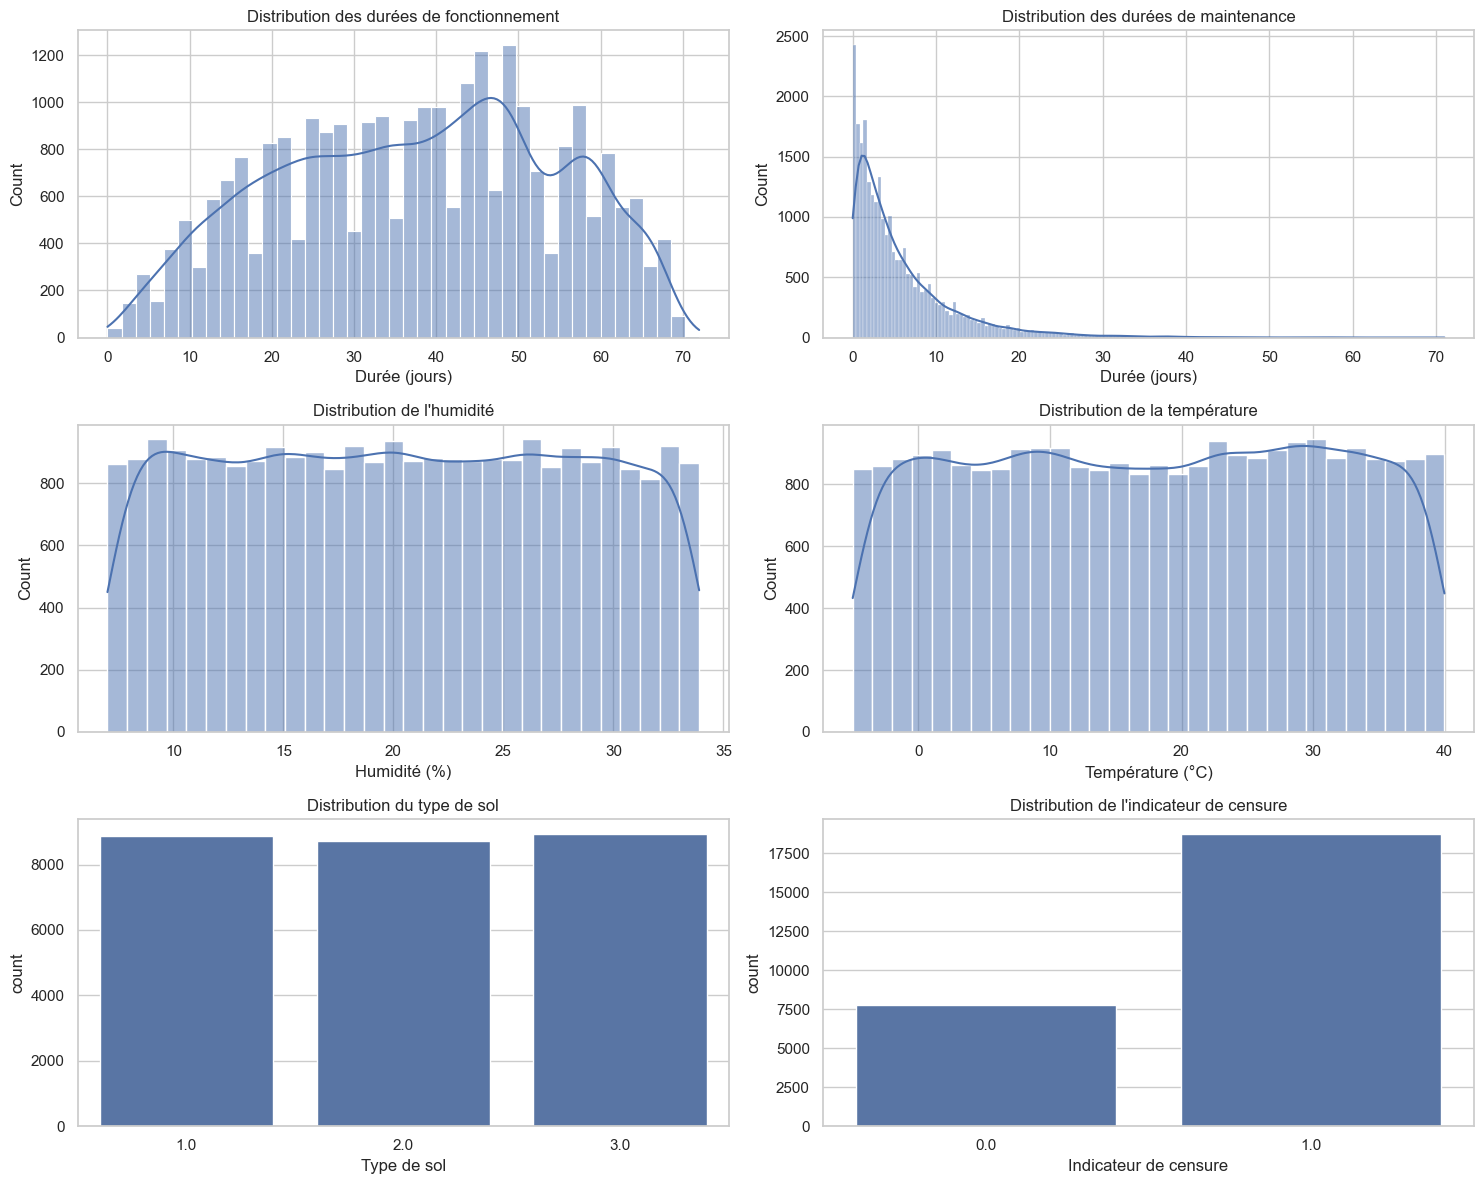

In [6]:
# Configuration de la figure
plt.figure(figsize=(15, 12))

# Distribution des durées de fonctionnement
plt.subplot(3, 2, 1)
sns.histplot(data_long_clean['duree_fonctionnement'], kde=True)
plt.title('Distribution des durées de fonctionnement')
plt.xlabel('Durée (jours)')

# Distribution des durées de maintenance
plt.subplot(3, 2, 2)
sns.histplot(data_long_clean['duree_maintenance'], kde=True)
plt.title('Distribution des durées de maintenance')
plt.xlabel('Durée (jours)')

# Distribution de l'humidité
plt.subplot(3, 2, 3)
sns.histplot(data_long_clean['humidite'], kde=True)
plt.title('Distribution de l\'humidité')
plt.xlabel('Humidité (%)')

# Distribution de la température
plt.subplot(3, 2, 4)
sns.histplot(data_long_clean['temperature'], kde=True)
plt.title('Distribution de la température')
plt.xlabel('Température (°C)')

# Distribution du type de sol
plt.subplot(3, 2, 5)
sns.countplot(x='nature_sol', data=data_long_clean)
plt.title('Distribution du type de sol')
plt.xlabel('Type de sol')

# Distribution de l'indicateur de censure
plt.subplot(3, 2, 6)
sns.countplot(x='indicateur_censure', data=data_long_clean)
plt.title('Distribution de l\'indicateur de censure')
plt.xlabel('Indicateur de censure')

plt.tight_layout()
plt.show()


## Statistiques descriptives
L'analyse des données nettoyées (après suppression des valeurs manquantes) révèle les caractéristiques suivantes :

| Variable | Moyenne | Écart-type | Min | 25% | 50% (Médiane) | 75% | Max |
|----------|---------|------------|-----|-----|---------------|-----|-----|
| Humidité | 20.41 | 7.78 | 7.0 | 13.7 | 20.4 | 27.1 | 33.9 |
| Température | 17.63 | 13.0 | -5.0 | 6.44 | 17.76 | 28.94 | 40.0 |
| Nature du sol | 2.00 | 0.82 | 1.0 | 1.0 | 2.0 | 3.0 | 3.0 |
| Distance | 29.55 | 17.29 | 0.0 | 14.0 | 30.0 | 45.0 | 59.0 |
| Nb techniciens | 1.49 | 0.50 | 1.0 | 1.0 | 1.0 | 2.0 | 2.0 |
| Durée fonctionnement | 37.62 | 16.68 | 0.0 | 24.0 | 39.0 | 50.0 | 72.0 |
| Indicateur censure | 0.71 | 0.46 | 0.0 | 0.0 | 1.0 | 1.0 | 1.0 |
| Durée maintenance | 5.89 | 6.59 | 0.0 | 1.5 | 3.7 | 7.9 | 71.0 |
| Maintenance précédente | 44.04 | 186.44 | 0.0 | 1.6 | 4.1 | 9.1 | 1428.0 |

Sur l'ensemble des données, nous disposons de 26 531 observations complètes (sans valeurs manquantes) pour 1 427 véhicules différents. Environ 70.6% des observations correspondent à de vraies défaillances (non censurées).

## Analses des distributions
L'analyse des distributions des variables principales révèle plusieurs points intéressants :
**Durée de fonctionnement :** La distribution présente une forme relativement symétrique, avec un pic autour de 40 jours. Cette distribution semble compatible avec une loi de Weibull, une hypothèse que nous vérifierons formellement.
**Durée de maintenance :** Cette variable présente une distribution fortement asymétrique à droite, avec une concentration de valeurs près de zéro et une longue queue. Ce type de distribution est caractéristique d'une loi exponentielle.
**Humidité et température :** Ces deux variables présentent des distributions uniformes sur leurs plages respectives, indiquant une bonne diversité des conditions climatiques dans notre jeu de données.
**Nature du sol :** Les observations se répartissent de manière relativement équilibrée entre les trois premiers types de sol (sable, boue, terre souple), avec une absence de sol de type 4 (terre ferme) dans les données analysées.
**Indicateur de censure :** Environ 70% des observations correspondent à de vraies défaillances (δ=1), tandis que 30% sont censurées (δ=0), ce qui est un taux de censure raisonnable pour l'analyse de survie.

## Corrélation entre variables

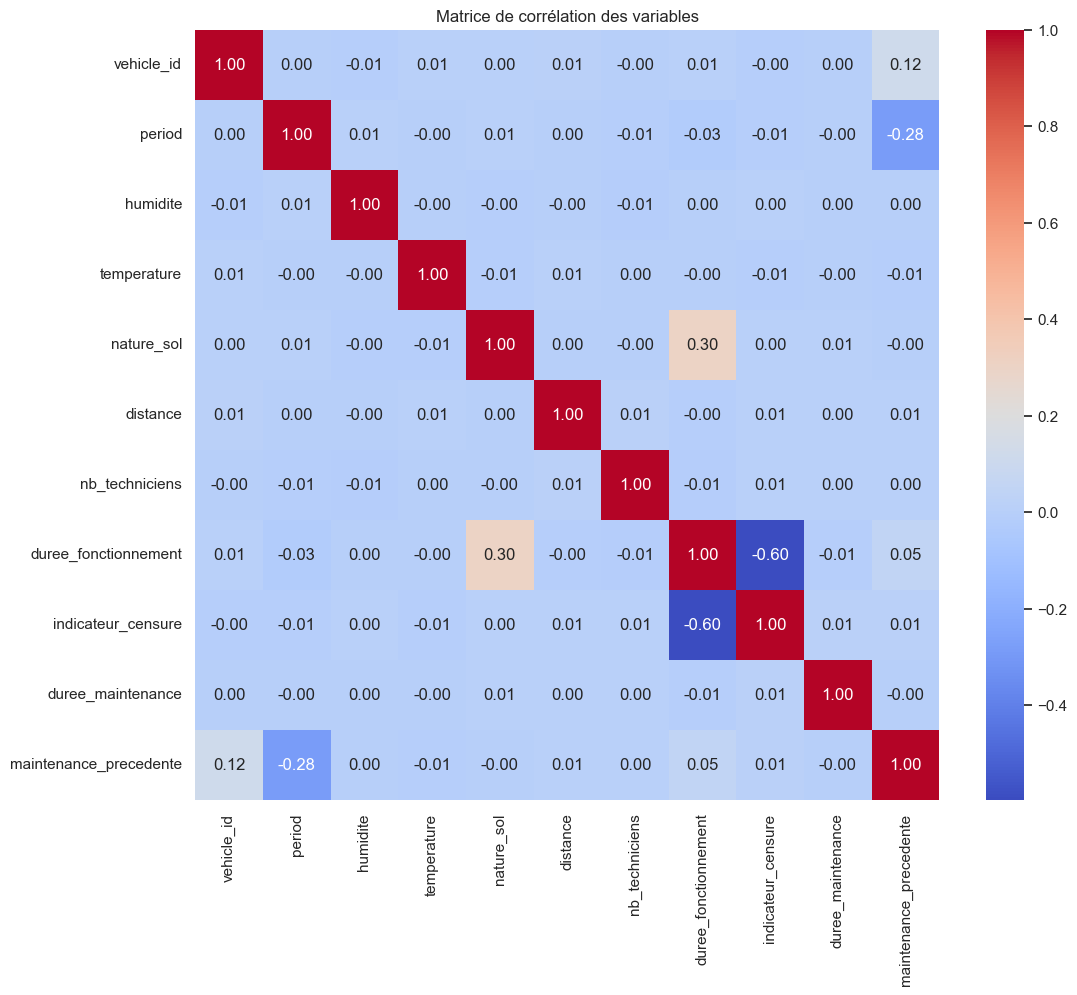

In [7]:
# Matrice de corrélation
correlation_matrix = data_long_clean.corr()

# Visualisation de la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation des variables')
plt.show()

La matrice de corrélation entre les variables montre :

1. Une corrélation positive significative (0.30) entre la durée de fonctionnement et la nature du sol, indiquant que les sols plus fermes (valeurs plus élevées) sont associés à des durées de fonctionnement plus longues.
2. Une corrélation négative (-0.60) entre la durée de fonctionnement et l'indicateur de censure, ce qui est logique car les observations censurées (δ=0) correspondent souvent à des arrêts prématurés du chantier, conduisant à des durées de fonctionnement plus courtes que les vraies défaillances.
3. Une faible corrélation entre les covariables météorologiques (humidité, température) et la durée de fonctionnement, suggérant que ces facteurs ont potentiellement un effet non-linéaire ou conditionnel.
4. Une corrélation positive modeste (0.05) entre la durée de fonctionnement et la maintenance précédente, indiquant qu'une maintenance plus longue pourrait légèrement améliorer la durée de fonctionnement suivante.

## Relations entre variables explicatives et variables cibles

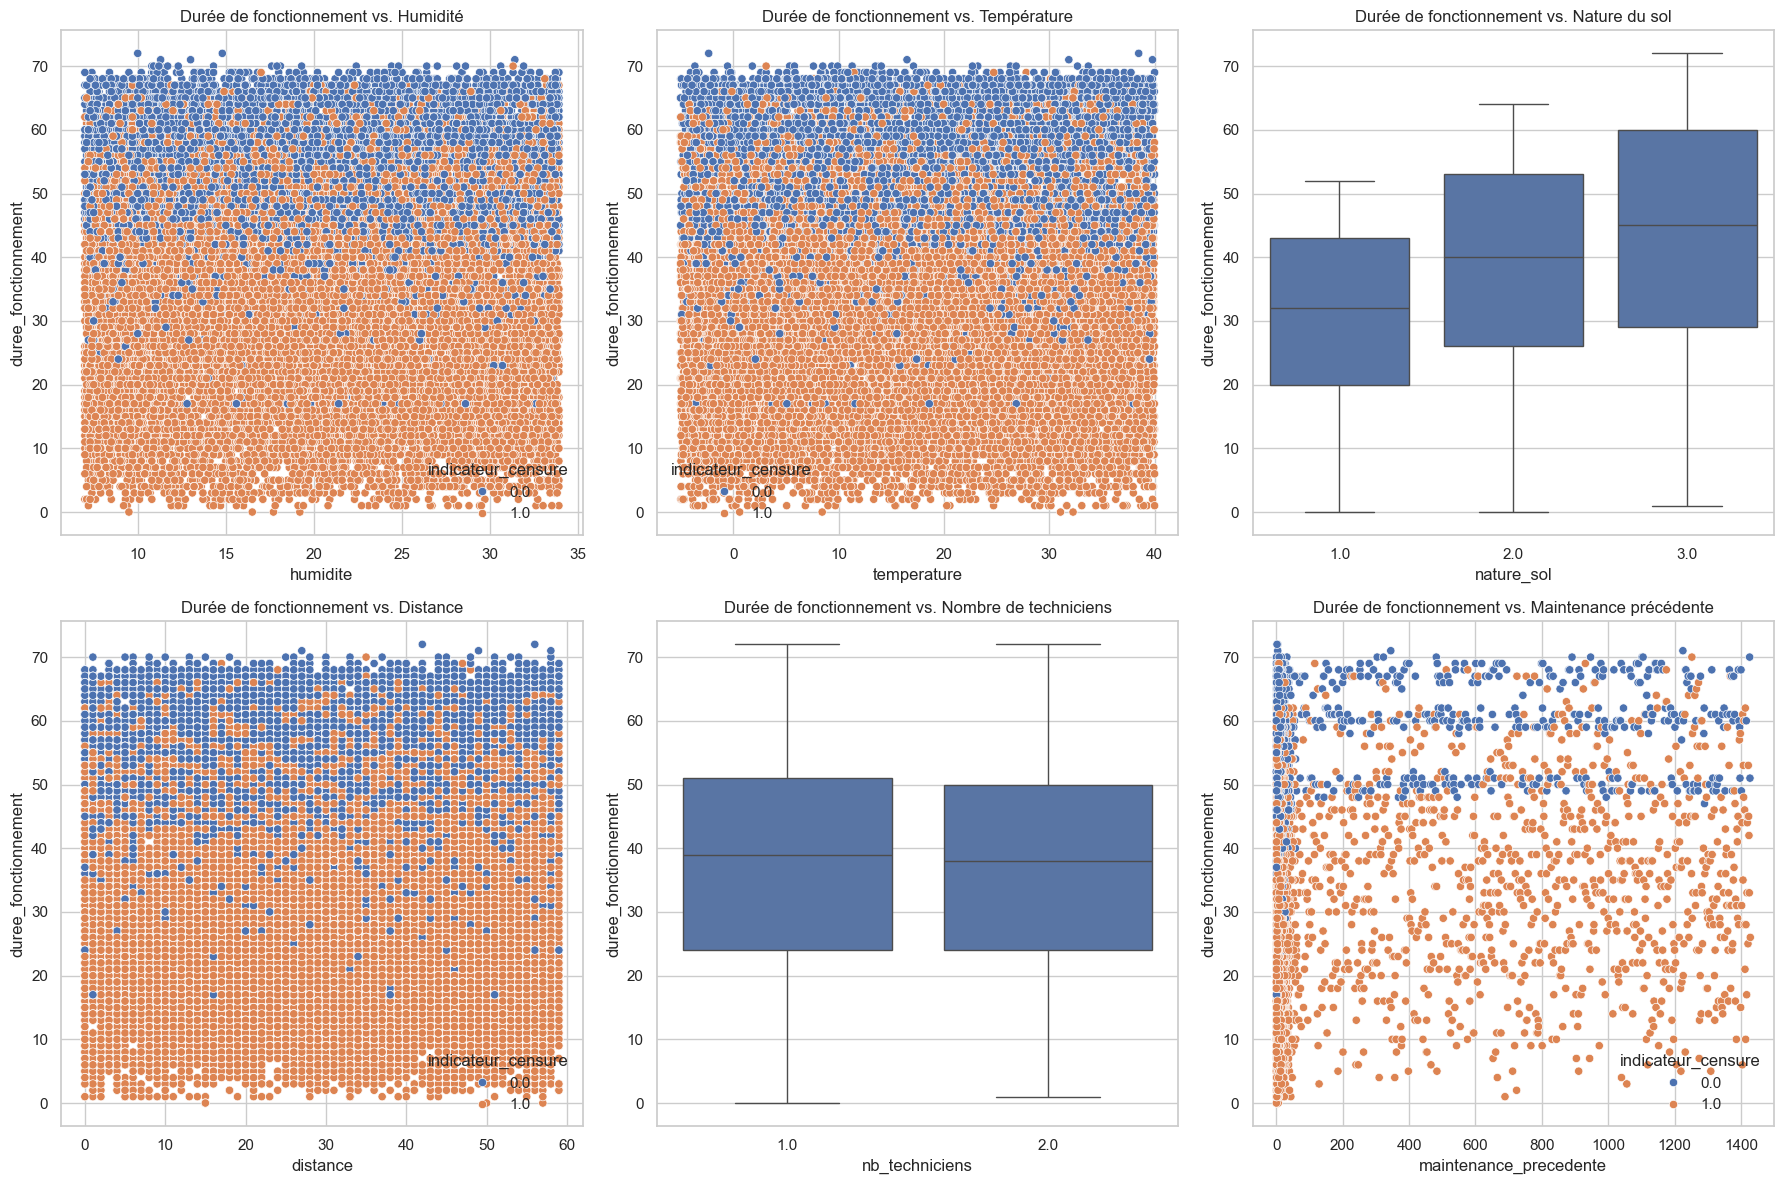

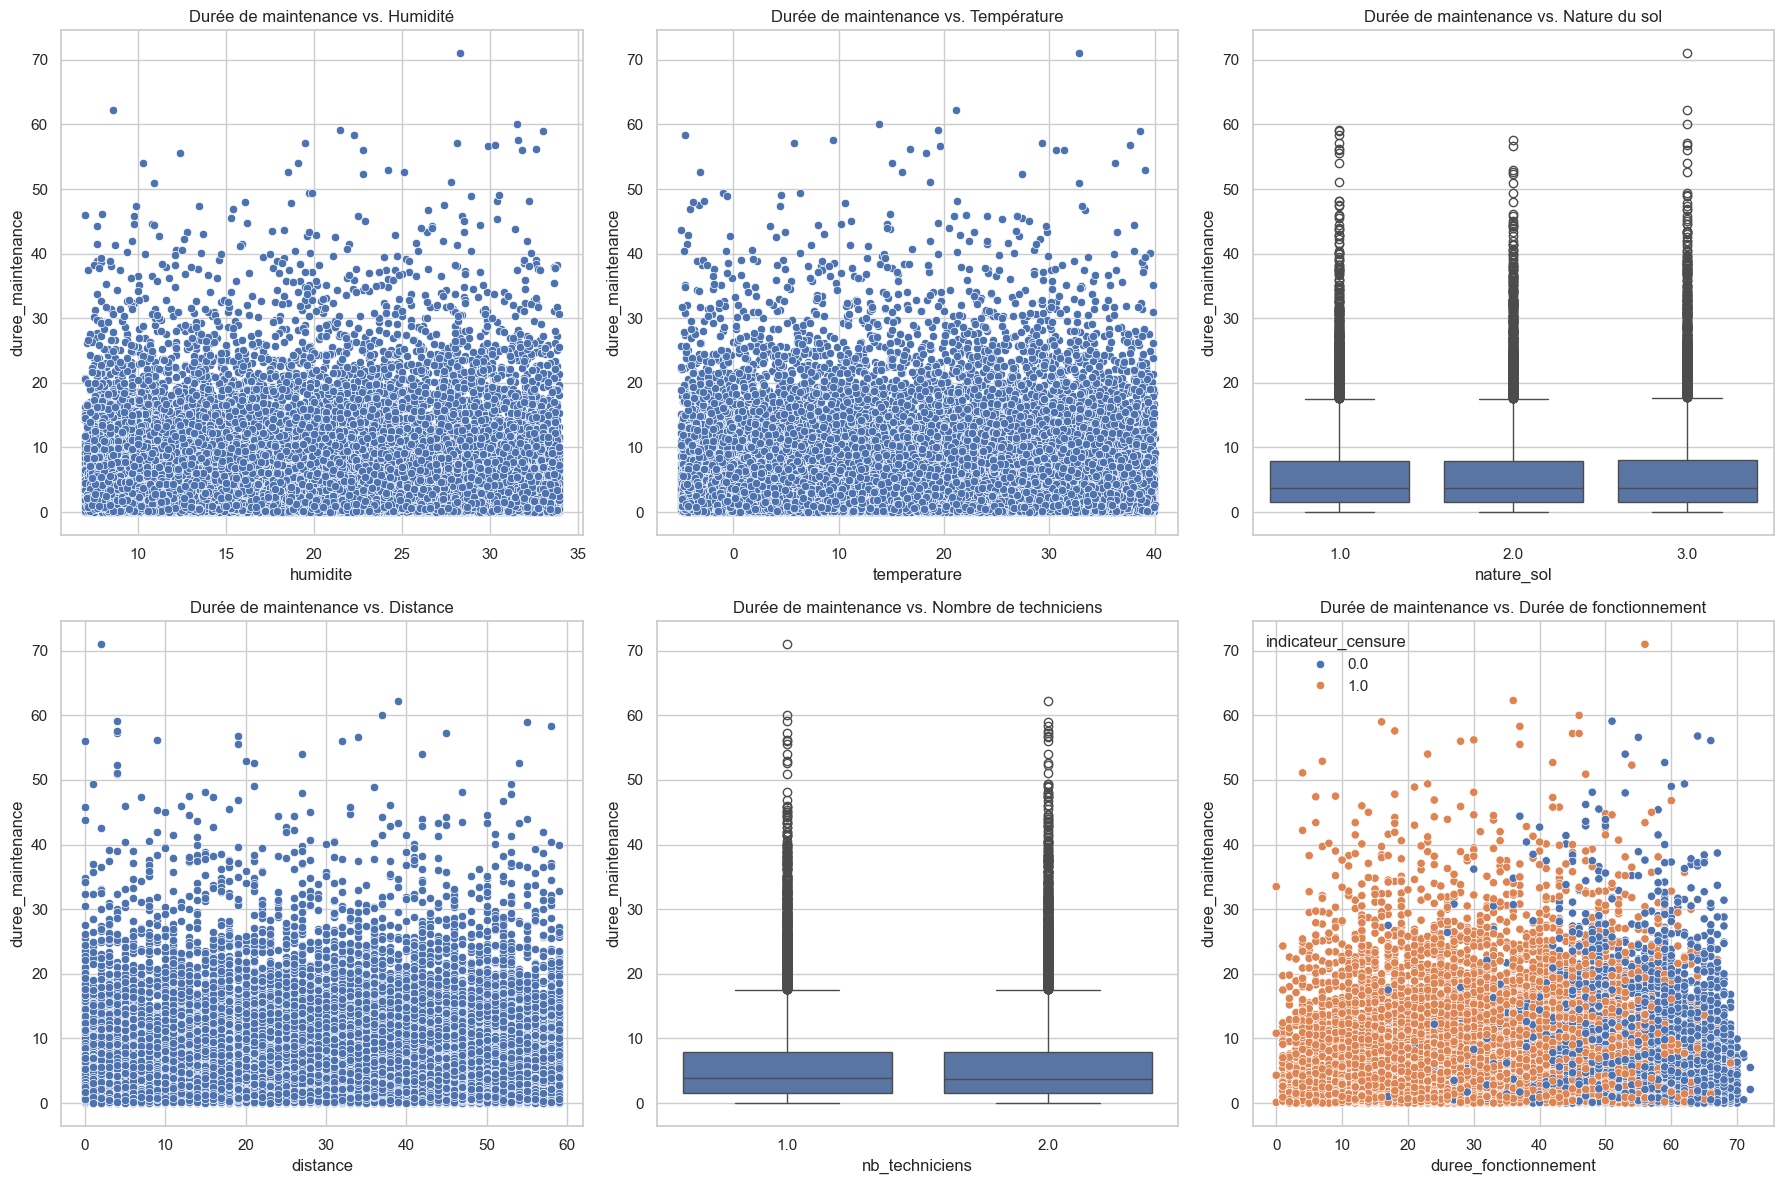

In [8]:
# Relation entre durée de fonctionnement et variables explicatives
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Durée de fonctionnement vs. humidité
sns.scatterplot(x='humidite', y='duree_fonctionnement', 
                hue='indicateur_censure', data=data_long_clean, ax=axes[0, 0])
axes[0, 0].set_title('Durée de fonctionnement vs. Humidité')

# Durée de fonctionnement vs. température
sns.scatterplot(x='temperature', y='duree_fonctionnement', 
                hue='indicateur_censure', data=data_long_clean, ax=axes[0, 1])
axes[0, 1].set_title('Durée de fonctionnement vs. Température')

# Durée de fonctionnement vs. nature du sol
sns.boxplot(x='nature_sol', y='duree_fonctionnement', data=data_long_clean, ax=axes[0, 2])
axes[0, 2].set_title('Durée de fonctionnement vs. Nature du sol')

# Durée de fonctionnement vs. distance
sns.scatterplot(x='distance', y='duree_fonctionnement', 
                hue='indicateur_censure', data=data_long_clean, ax=axes[1, 0])
axes[1, 0].set_title('Durée de fonctionnement vs. Distance')

# Durée de fonctionnement vs. nombre de techniciens
sns.boxplot(x='nb_techniciens', y='duree_fonctionnement', data=data_long_clean, ax=axes[1, 1])
axes[1, 1].set_title('Durée de fonctionnement vs. Nombre de techniciens')

# Durée de fonctionnement vs. maintenance précédente
sns.scatterplot(x='maintenance_precedente', y='duree_fonctionnement', 
                hue='indicateur_censure', data=data_long_clean, ax=axes[1, 2])
axes[1, 2].set_title('Durée de fonctionnement vs. Maintenance précédente')

plt.tight_layout()
plt.show()

# Analyse de la durée de maintenance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Durée de maintenance vs. humidité
sns.scatterplot(x='humidite', y='duree_maintenance', data=data_long_clean, ax=axes[0, 0])
axes[0, 0].set_title('Durée de maintenance vs. Humidité')

# Durée de maintenance vs. température
sns.scatterplot(x='temperature', y='duree_maintenance', data=data_long_clean, ax=axes[0, 1])
axes[0, 1].set_title('Durée de maintenance vs. Température')

# Durée de maintenance vs. nature du sol
sns.boxplot(x='nature_sol', y='duree_maintenance', data=data_long_clean, ax=axes[0, 2])
axes[0, 2].set_title('Durée de maintenance vs. Nature du sol')

# Durée de maintenance vs. distance
sns.scatterplot(x='distance', y='duree_maintenance', data=data_long_clean, ax=axes[1, 0])
axes[1, 0].set_title('Durée de maintenance vs. Distance')

# Durée de maintenance vs. nombre de techniciens
sns.boxplot(x='nb_techniciens', y='duree_maintenance', data=data_long_clean, ax=axes[1, 1])
axes[1, 1].set_title('Durée de maintenance vs. Nombre de techniciens')

# Durée de maintenance vs. durée de fonctionnement
sns.scatterplot(x='duree_fonctionnement', y='duree_maintenance', 
                hue='indicateur_censure', data=data_long_clean, ax=axes[1, 2])
axes[1, 2].set_title('Durée de maintenance vs. Durée de fonctionnement')

plt.tight_layout()
plt.show()

L'analyse des relations bivariées entre les variables explicatives et les variables cibles a révélé plusieurs tendances :
- **Nature du sol et durée de fonctionnement :** Les boxplots montrent une augmentation claire de la durée médiane de fonctionnement avec la fermeté du sol. Les véhicules fonctionnent significativement plus longtemps sur des sols de type 3 (terre souple) que sur des sols de type 1 (sable).
- **Température et durée de fonctionnement :** Une légère tendance positive est observable, mais avec une grande dispersion. L'effet de la température semble modéré par rapport à d'autres facteurs.
- **Maintenance précédente et durée de fonctionnement :** On observe une légère tendance positive, mais avec beaucoup de dispersion. Une maintenance plus longue semble associée à une durée de fonctionnement légèrement plus élevée, mais cette relation n'est pas très marquée.
- **Distance et durée de maintenance :** La distance à la ville la plus proche ne semble pas avoir d'impact majeur sur la durée de maintenance, malgré une légère tendance positive.
- **Nombre de techniciens et durée de maintenance :** De manière surprenante, il n'y a pas de différence significative entre les durées de maintenance selon le nombre de techniciens (1 ou 2).
- 
Ces observations préliminaires guideront le choix de nos modèles et l'interprétation des résultats.

# Modélisation
## Choix des modèles probabilistes

Pour modéliser les durées de fonctionnement et de maintenance, nous avons sélectionné deux distributions probabilistes adaptées aux données de survie :

1. **Loi de Weibull** pour la durée de fonctionnement (Y)

La loi de Weibull est particulièrement adaptée pour modéliser la durée de vie des équipements mécaniques. Sa fonction de densité s'écrit :

$$f_W(y|\eta, \beta) = \frac{\beta}{\eta}\left(\frac{y}{\eta}\right)^{\beta-1}e^{-\left(\frac{y}{\eta}\right)^{\beta}} \mathbb{1}_{\{y \geq 0\}}$$

où:
- $\eta > 0$ est le paramètre d'échelle (lié à la durée de vie caractéristique)
- $\beta > 0$ est le paramètre de forme qui contrôle la forme de la distribution

Pour notre modèle, nous supposons que $Y|X,T,\theta_1 \sim W(\eta = g_1(X,T,\theta_1), \beta)$ où $g_1$ est une fonction paramétrée par $\theta_1$ qui lie les covariables au paramètre d'échelle $\eta$.

2. **Loi exponentielle** pour la durée de maintenance (T)

La loi exponentielle, cas particulier de la loi de Weibull avec $\beta=1$, est souvent utilisée pour modéliser des temps d'attente ou de service. Sa fonction de densité est :

$$f_E(t|\lambda) = \lambda^{-1}e^{-\lambda t} \mathbb{1}_{\{t \geq 0\}}$$

où $\lambda > 0$ est le taux moyen d'événements. Pour notre modèle, nous supposons que $T|\tilde{X},\theta_2 \sim E(\lambda = g_2(\tilde{X},\theta_2))$ où $g_2$ est une fonction paramétrée par $\theta_2$.

## Adéquation des lois théoriques

Paramètres estimés de la loi de Weibull : shape (β) = 2.2568156660073684, scale (η) = 35.183963825597225


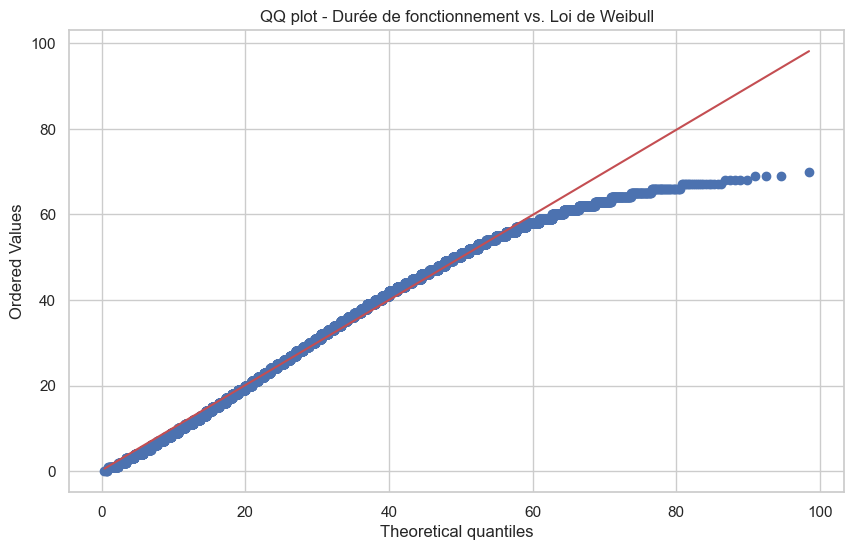

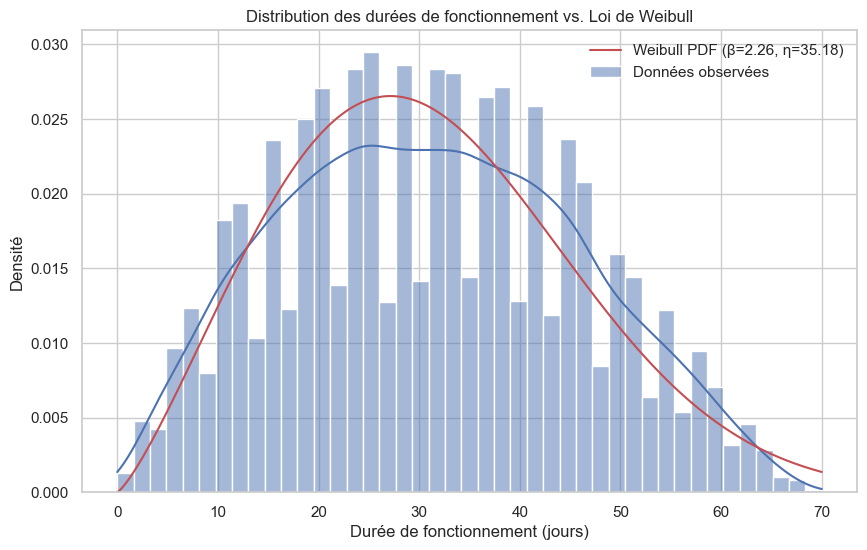

In [9]:
# Filtrage des données non censurées pour l'ajustement de la loi de Weibull
non_censored_data = data_long_clean[data_long_clean['indicateur_censure'] == 1]['duree_fonctionnement']

# Estimation des paramètres de la loi de Weibull
shape, loc, scale = stats.weibull_min.fit(non_censored_data, floc=0)
print(f"Paramètres estimés de la loi de Weibull : shape (β) = {shape}, scale (η) = {scale}")

# QQ Plot pour vérifier l'adéquation à la loi de Weibull
plt.figure(figsize=(10, 6))
stats.probplot(non_censored_data, dist=stats.weibull_min, sparams=(shape, loc, scale), plot=plt)
plt.title('QQ plot - Durée de fonctionnement vs. Loi de Weibull')
plt.show()

# Visualisation de la distribution des durées de fonctionnement avec la PDF de Weibull ajustée
plt.figure(figsize=(10, 6))
sns.histplot(non_censored_data, kde=True, stat='density', label='Données observées')

# Création d'une grille pour tracer la PDF de Weibull
x = np.linspace(0, non_censored_data.max(), 1000)
pdf = stats.weibull_min.pdf(x, shape, loc, scale)
plt.plot(x, pdf, 'r-', label=f'Weibull PDF (β={shape:.2f}, η={scale:.2f})')

plt.title('Distribution des durées de fonctionnement vs. Loi de Weibull')
plt.xlabel('Durée de fonctionnement (jours)')
plt.ylabel('Densité')
plt.legend()
plt.show()

Paramètres estimés de la loi exponentielle : λ = 0.1699176958158784


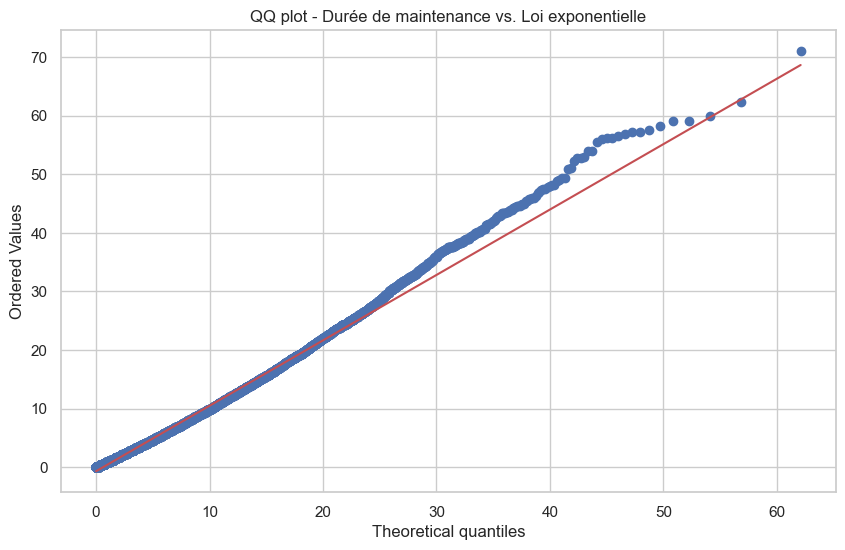

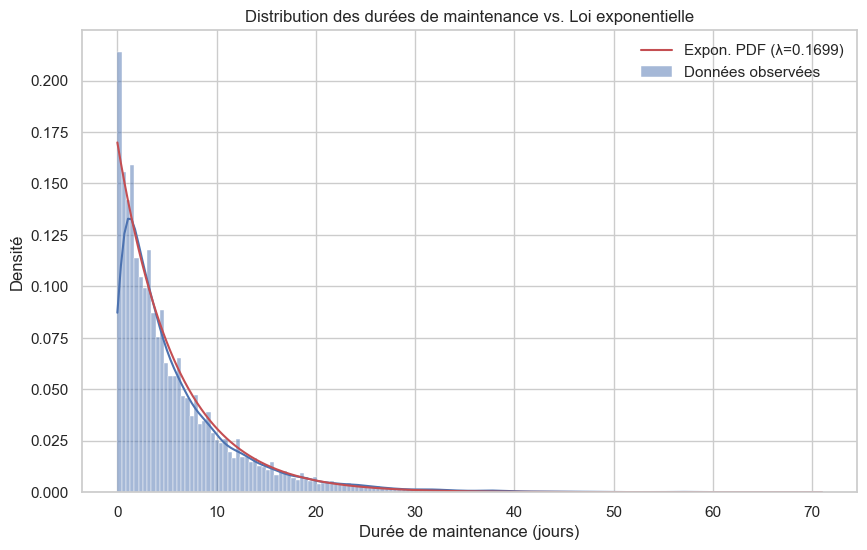

In [10]:
# Estimation du paramètre de la loi exponentielle
loc, scale = stats.expon.fit(data_long_clean['duree_maintenance'])
print(f"Paramètres estimés de la loi exponentielle : λ = {1/scale}")

# QQ Plot pour vérifier l'adéquation à la loi exponentielle
plt.figure(figsize=(10, 6))
stats.probplot(data_long_clean['duree_maintenance'], dist=stats.expon, sparams=(loc, scale), plot=plt)
plt.title('QQ plot - Durée de maintenance vs. Loi exponentielle')
plt.show()

# Visualisation de la distribution des durées de maintenance avec la PDF exponentielle ajustée
plt.figure(figsize=(10, 6))
sns.histplot(data_long_clean['duree_maintenance'], kde=True, stat='density', label='Données observées')

# Création d'une grille pour tracer la PDF exponentielle
x = np.linspace(0, data_long_clean['duree_maintenance'].max(), 1000)
pdf = stats.expon.pdf(x, loc, scale)
plt.plot(x, pdf, 'r-', label=f'Expon. PDF (λ={1/scale:.4f})')

plt.title('Distribution des durées de maintenance vs. Loi exponentielle')
plt.xlabel('Durée de maintenance (jours)')
plt.ylabel('Densité')
plt.legend()
plt.show()

Pour vérifier l'adéquation de nos choix de distributions, nous avons effectué des tests graphiques et d'ajustement.

**Pour la loi de Weibull (durée de fonctionnement) :**

- Estimation des paramètres sur les données non censurées : $\beta \approx 2.26$, $\eta \approx 35.18$
- Q-Q plot : Bonne adéquation pour la majorité des données, avec quelques déviations dans les queues de distribution
- Histogramme avec superposition de la densité : Correspondance visuelle satisfaisante

**Pour la loi exponentielle (durée de maintenance) :**

- Estimation du paramètre : $\lambda \approx 0.17$ (taux moyen)
- Q-Q plot : Adéquation acceptable, avec une légère déviation pour les valeurs extrêmes
- Histogramme avec superposition de la densité : Bonne correspondance pour la forme générale de la distribution

Ces analyses confirment que nos choix de distributions sont appropriés pour modéliser les données observées.

In [11]:
# Sélection des covariables pour le modèle de durée de fonctionnement (g1)
X_features = ['humidite', 'temperature', 'nature_sol', 'maintenance_precedente']

# Sélection des covariables pour le modèle de durée de maintenance (g2)
X_tilde_features = ['distance', 'nb_techniciens']

# Extraction des données pour les modèles
X = data_long_clean[X_features].values
X_tilde = data_long_clean[X_tilde_features].values
Y = data_long_clean['duree_fonctionnement'].values
delta = data_long_clean['indicateur_censure'].values
T = data_long_clean['duree_maintenance'].values

In [12]:
# Normalisation des données pour améliorer la stabilité numérique
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X_tilde = StandardScaler()
scaler_Y = StandardScaler()
scaler_T = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
X_tilde_scaled = scaler_X_tilde.fit_transform(X_tilde)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1)).flatten()
T_scaled = scaler_T.fit_transform(T.reshape(-1, 1)).flatten()

# Division des données en ensembles d'entraînement et de test
X_train, X_test, X_tilde_train, X_tilde_test, Y_train, Y_test, delta_train, delta_test, T_train, T_test = train_test_split(
    X_scaled, X_tilde_scaled, Y_scaled, delta, T_scaled, test_size=0.2, random_state=42)

## Specification des fonctions $g_1$ et $g_2$

Pour relier les covariables aux paramètres des distributions, nous avons implémenté deux approches :

1. **Modèles linéaires** :

$$g_1(X, T, \theta_1) = \exp(\theta_{1,0} + \theta_{1,1}x_1 + ... + \theta_{1,d}x_d + \theta_{1,d+1}t)$$

$$g_2(\tilde{X}, \theta_2) = \exp(\theta_{2,0} + \theta_{2,1}\tilde{x}_1 + ... + \theta_{2,d}\tilde{x}_d)$$

La transformation exponentielle garantit la positivité des paramètres $\eta$ et $\lambda$.

2. **Réseaux de neurones** :

Pour capturer les relations non-linéaires potentielles, nous avons également développé des modèles basés sur des réseaux de neurones :

$$g_1(X, T, \theta_1) = \exp(f_{\theta_1}(X, T))$$

$$g_2(\tilde{X}, \theta_2) = \exp(f_{\theta_2}(\tilde{X}))$$

où $f_{\theta_1}$ et $f_{\theta_2}$ sont des réseaux de neurones à deux couches cachées avec activation ReLU, régularisation L2, normalisation par lots et dropout pour éviter le surapprentissage.

## Formulation Bayésienne 

Notre approche bayésienne requiert la spécification de distributions a priori pour les paramètres des modèles :

1. **Pour les coefficients des modèles linéaires** :
   - $\theta_{1,j} \sim \mathcal{N}(0, 1)$ pour j = 0, ..., d+1
   - $\theta_{2,j} \sim \mathcal{N}(0, 1)$ pour j = 0, ..., d

2. **Pour le paramètre de forme de Weibull** :
   - $\beta \sim \text{TBeta}(2, 2, 1, 3)$ (distribution Beta tronquée sur l'intervalle [1, 3])

3. **Pour les poids des réseaux neuronaux** :
   - $W^{(1)}_j \sim \mathcal{N}(0, \tau_j^2)$
   - $W^{(2)}_j \sim \mathcal{N}(0, \nu_j^2)$
   - $\tau_j^2 \sim \text{IG}(\alpha_{\tau}, \beta_{\tau})$
   - $\nu_j^2 \sim \text{IG}(\alpha_{\nu}, \beta_{\nu})$

Ces distributions a priori intègrent nos connaissances préalables sur les plages de valeurs plausibles des paramètres et imposent une régularisation naturelle sur les modèles.

# Estimation et inférence

## Maximum de vraisemblance

Nous avons d'abord estimé les paramètres par maximum de vraisemblance (MLE), en tenant compte de la censure pour le modèle de Weibull.

La log-vraisemblance pour le modèle de Weibull avec censure s'écrit :

$$\log L(\theta_1, \beta|X, Y, \delta) = \sum_{i,k: \delta_{i,k}=1} \left[\log \beta - \beta \log \eta_{i,k} + (\beta-1)\log y_{i,k} - \left(\frac{y_{i,k}}{\eta_{i,k}}\right)^\beta\right] + \sum_{i,k: \delta_{i,k}=0} \left[-\left(\frac{y_{i,k}}{\eta_{i,k}}\right)^\beta\right]$$

où $\eta_{i,k} = g_1(x_{i,k}, t_{i,k-1}, \theta_1)$.

Pour le modèle exponentiel, la log-vraisemblance est :

$$\log L(\theta_2|\tilde{X}, T) = \sum_{i,k} \left[-\log \lambda_{i,k} - t_{i,k}\lambda_{i,k}\right]$$

où $\lambda_{i,k} = g_2(\tilde{x}_{i,k}, \theta_2)$.

Les résultats de l'estimation MLE pour le modèle linéaire ont donné :

- Modèle g₁ (Weibull) : $\theta_1 = [-0.0092, -0.0009, 0.5548, 0.0654]$, $\beta = 1.0$
- Modèle g₂ (Exponentiel) : $\theta_2 = [-0.0170, -0.0044]$

Le paramètre $\beta = 1$ est à la limite inférieure de la contrainte [1, 3], ce qui indique que la distribution des durées de fonctionnement est proche d'une exponentielle.

In [13]:
# Définition des modèles linéaires pour g1 et g2
def g1_linear(X, theta1):
    """Modèle linéaire pour le paramètre η de la loi de Weibull."""
    return np.exp(np.dot(X, theta1))  # Utilisation de l'exponentielle pour garantir η > 0

def g2_linear(X_tilde, theta2):
    """Modèle linéaire pour le paramètre λ de la loi exponentielle."""
    return np.exp(np.dot(X_tilde, theta2))  # Utilisation de l'exponentielle pour garantir λ > 0

# Fonction de log-vraisemblance pour le modèle de Weibull avec censure
def log_likelihood_weibull(params, X, Y, delta):
    theta1 = params[:-1]
    beta = params[-1]
    
    # Protection contre les valeurs invalides de beta
    if beta <= 0.5 or beta > 3.5:
        return 1e10  # Pénalité importante
    
    # Calcul de eta avec protection contre les débordements
    eta_raw = np.dot(X, theta1)
    # Limitation des valeurs extrêmes pour éviter l'overflow lors de l'exponentielle
    eta_raw = np.clip(eta_raw, -20, 20)
    eta = np.exp(eta_raw)
    
    # Protection contre les divisions par zéro et les valeurs négatives
    eta = np.maximum(eta, 1e-10)
    Y_safe = np.maximum(Y, 1e-10)
    
    # Calcul de la log-vraisemblance de manière plus robuste
    log_beta = np.log(beta)
    beta_log_eta = beta * np.log(eta)
    beta_minus_1_log_Y = (beta - 1) * np.log(Y_safe)
    
    # Calculer (Y/eta)^beta de manière plus stable
    Y_over_eta = Y_safe / eta
    # Limiter les valeurs pour éviter l'overflow
    Y_over_eta = np.minimum(Y_over_eta, 100)
    power_term = np.power(Y_over_eta, beta)
    
    # Calcul séparé pour les données censurées et non censurées
    ll_non_censored = np.sum(delta * (log_beta - beta_log_eta + beta_minus_1_log_Y - power_term))
    ll_censored = np.sum((1 - delta) * (-power_term))
    
    # Vérifiez que le résultat est fini
    result = -(ll_non_censored + ll_censored)  # Négatif car on minimise
    if not np.isfinite(result):
        return 1e10  # Retourner une grande valeur finie en cas d'erreur
    
    return result

# Fonction de log-vraisemblance pour le modèle exponentiel
def log_likelihood_exponential(params, X_tilde, T):
    theta2 = params
    
    lambda_param = g2_linear(X_tilde, theta2)
    
    # Calcul de la log-vraisemblance pour la loi exponentielle
    ll = np.sum(-np.log(lambda_param) - T * lambda_param)
    
    return -ll  # Négatif car on minimise

In [14]:
# Optimisation des modèles linéaires pour g1 et g2
from scipy.optimize import minimize

# Estimation des paramètres de g1 (modèle de Weibull) par maximum de vraisemblance
initial_params_g1 = np.zeros(X_train.shape[1] + 1)
initial_params_g1[0] = 0.01  # Petit effet positif pour l'humidité
initial_params_g1[1] = -0.01  # Petit effet négatif pour la température
initial_params_g1[2] = 0.3  # Effet positif pour la nature du sol (visible dans les boxplots)
initial_params_g1[3] = 0.05  # Petit effet positif pour la maintenance précédente
initial_params_g1[-1] = 2.0  # Valeur de beta dans l'intervalle [1, 3]

# Définir des bornes pour les paramètres
bounds_g1 = [(None, None)] * X_train.shape[1] + [(1.0, 3.0)]  # Borne pour beta

# Optimisation pour g1 avec une méthode plus robuste et des bornes
result_g1 = minimize(
    log_likelihood_weibull,
    initial_params_g1,
    args=(X_train, Y_train, delta_train),
    method='L-BFGS-B',  # Méthode qui prend en compte les bornes
    bounds=bounds_g1,
    options={'maxiter': 10000}
)

# Vérifiez la convergence
if not result_g1.success:
    print(f"Avertissement: L'optimisation n'a pas convergé. Message: {result_g1.message}")

theta1_mle = result_g1.x[:-1]
beta_mle = result_g1.x[-1]
print(f"Paramètres estimés de g1 (coefficients): {theta1_mle}")
print(f"Paramètre beta estimé: {beta_mle}")
print(f"Log-vraisemblance du modèle g1: {-result_g1.fun}")

# Estimation des paramètres de g2 (modèle exponentiel) par maximum de vraisemblance
initial_params_g2 = np.zeros(X_tilde_train.shape[1])
initial_params_g2[0] = 0.01  # Initialisation pour distance
initial_params_g2[1] = -0.01  # Initialisation pour nb_techniciens

# Fonction de log-vraisemblance robuste pour le modèle exponentiel
def log_likelihood_exponential_robust(params, X_tilde, T):
    theta2 = params
    
    # Calcul du paramètre lambda avec protection
    lambda_raw = np.dot(X_tilde, theta2)
    lambda_raw = np.clip(lambda_raw, -20, 20)  # Limiter les valeurs extrêmes
    lambda_param = np.exp(lambda_raw)
    lambda_param = np.maximum(lambda_param, 1e-10)  # Éviter division par zéro
    T_safe = np.maximum(T, 1e-10)  # Protection contre valeurs négatives
    
    # Calcul de la log-vraisemblance pour la loi exponentielle
    ll = np.sum(-np.log(lambda_param) - T_safe * lambda_param)
    
    # Vérifier que le résultat est fini
    if not np.isfinite(ll):
        return 1e10
    
    return -ll  # Négatif car on minimise

# Optimisation pour g2
result_g2 = minimize(
    log_likelihood_exponential_robust,
    initial_params_g2,
    args=(X_tilde_train, T_train),
    method='L-BFGS-B',
    options={'maxiter': 10000}
)

# Vérification de la convergence
if not result_g2.success:
    print(f"Avertissement: L'optimisation pour g2 n'a pas convergé. Message: {result_g2.message}")

theta2_mle = result_g2.x
print(f"Paramètres estimés de g2 (coefficients): {theta2_mle}")
print(f"Log-vraisemblance du modèle g2: {-result_g2.fun}")

Paramètres estimés de g1 (coefficients): [-0.00917772 -0.00086906  0.55477382  0.0653841 ]
Paramètre beta estimé: 1.0
Log-vraisemblance du modèle g1: -7836.790777447378
Paramètres estimés de g2 (coefficients): [-0.01699714 -0.00438472]
Log-vraisemblance du modèle g2: -7538.063528919375


In [15]:
# Évaluation des modèles sur l'ensemble de test
def evaluate_weibull_model(X, Y, delta, theta1, beta):
    try:
        # Protection des paramètres
        beta = max(1.0, min(3.0, beta))  # S'assurer que beta est dans [1, 3]
        
        # Calcul de eta de manière robuste
        eta_raw = np.dot(X, theta1)
        eta_raw = np.clip(eta_raw, -20, 20)
        eta = np.exp(eta_raw)
        eta = np.maximum(eta, 1e-10)
        Y_safe = np.maximum(Y, 1e-10)
        
        # Calcul de la log-vraisemblance
        log_beta = np.log(beta)
        beta_log_eta = beta * np.log(eta)
        beta_minus_1_log_Y = (beta - 1) * np.log(Y_safe)
        Y_over_eta = np.minimum(Y_safe / eta, 100)  # Limiter pour éviter l'overflow
        power_term = np.power(Y_over_eta, beta)
        
        ll_non_censored = np.sum(delta * (log_beta - beta_log_eta + beta_minus_1_log_Y - power_term))
        ll_censored = np.sum((1 - delta) * (-power_term))
        log_likelihood = ll_non_censored + ll_censored
        
        # Pour les données non censurées, calculer l'erreur quadratique moyenne
        if np.sum(delta) > 0:
            y_pred = eta * np.power(np.log(2), 1/beta)  # Médiane de la distribution Weibull
            mse = np.mean(delta * ((Y - y_pred) ** 2))
            rmse = np.sqrt(mse)
        else:
            mse = np.nan
            rmse = np.nan
        
        return log_likelihood, mse, rmse
    except Exception as e:
        print(f"Erreur dans evaluate_weibull_model: {e}")
        return np.nan, np.nan, np.nan

def evaluate_exponential_model(X_tilde, T, theta2):
    try:
        # Calcul de lambda de manière robuste
        lambda_raw = np.dot(X_tilde, theta2)
        lambda_raw = np.clip(lambda_raw, -20, 20)
        lambda_param = np.exp(lambda_raw)
        lambda_param = np.maximum(lambda_param, 1e-10)
        T_safe = np.maximum(T, 1e-10)
        
        # Calcul de la log-vraisemblance
        log_likelihood = np.sum(-np.log(lambda_param) - T_safe * lambda_param)
        
        # Erreur quadratique moyenne
        t_pred = 1 / lambda_param  # Espérance de la loi exponentielle
        mse = np.mean((T - t_pred) ** 2)
        rmse = np.sqrt(mse)
        
        return log_likelihood, mse, rmse
    except Exception as e:
        print(f"Erreur dans evaluate_exponential_model: {e}")
        return np.nan, np.nan, np.nan

# Évaluation du modèle de Weibull sur l'ensemble de test
ll_g1_test, mse_g1_test, rmse_g1_test = evaluate_weibull_model(X_test, Y_test, delta_test, theta1_mle, beta_mle)
print(f"Évaluation du modèle g1 sur l'ensemble de test:")
print(f"Log-vraisemblance: {ll_g1_test}")
print(f"MSE: {mse_g1_test}")
print(f"RMSE: {rmse_g1_test}")

# Évaluation du modèle exponentiel sur l'ensemble de test
ll_g2_test, mse_g2_test, rmse_g2_test = evaluate_exponential_model(X_tilde_test, T_test, theta2_mle)
print(f"Évaluation du modèle g2 sur l'ensemble de test:")
print(f"Log-vraisemblance: {ll_g2_test}")
print(f"MSE: {mse_g2_test}")
print(f"RMSE: {rmse_g2_test}")

Évaluation du modèle g1 sur l'ensemble de test:
Log-vraisemblance: -1955.1900945206507
MSE: 1.504712338714139
RMSE: 1.2266671670482336
Évaluation du modèle g2 sur l'ensemble de test:
Log-vraisemblance: -1798.6816722574092
MSE: 2.0025555535287762
RMSE: 1.415116798546599


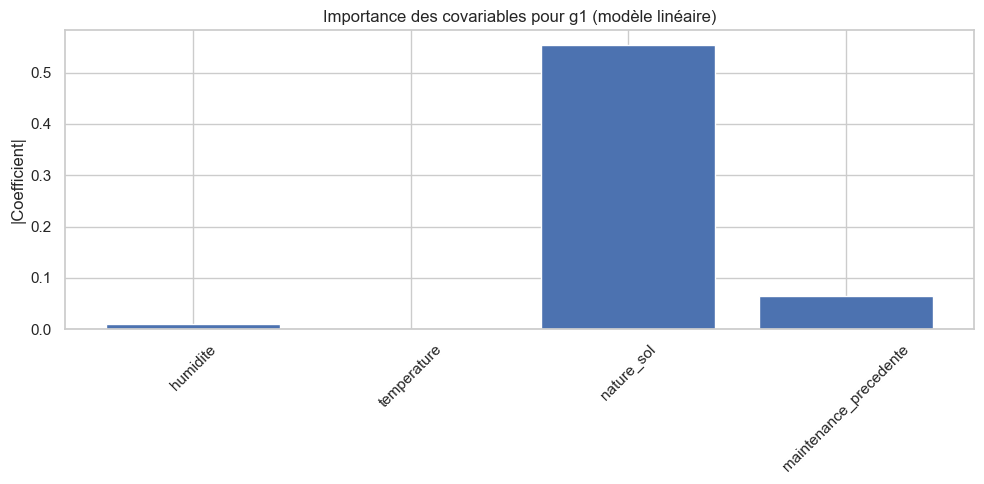

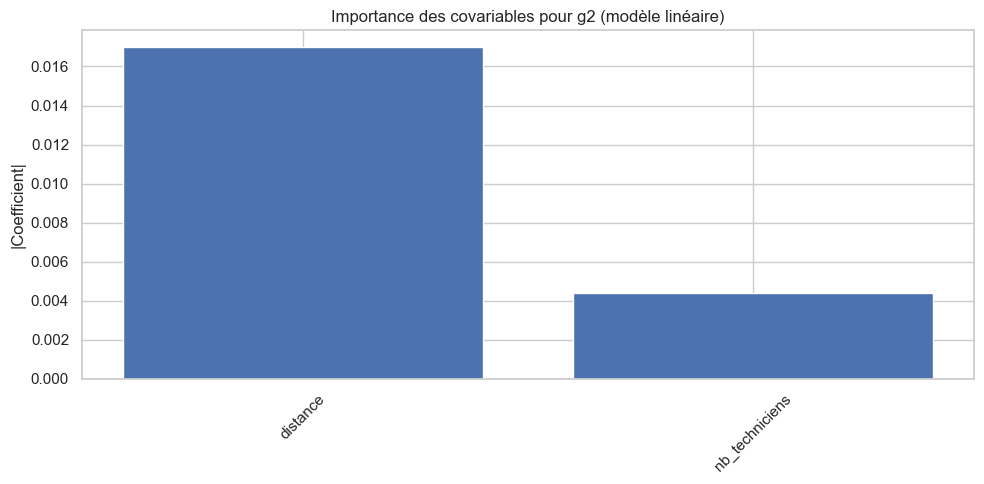

In [16]:
# Analyse de l'importance des covariables pour g1
plt.figure(figsize=(10, 5))
feature_importance_g1 = np.abs(theta1_mle)
plt.bar(X_features, feature_importance_g1)
plt.title('Importance des covariables pour g1 (modèle linéaire)')
plt.ylabel('|Coefficient|')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyse de l'importance des covariables pour g2
plt.figure(figsize=(10, 5))
feature_importance_g2 = np.abs(theta2_mle)
plt.bar(X_tilde_features, feature_importance_g2)
plt.title('Importance des covariables pour g2 (modèle linéaire)')
plt.ylabel('|Coefficient|')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Modèles neuronaux

Pour les modèles neuronaux, nous avons utilisé une architecture avec deux couches cachées (8 et 4 neurones) et fonction d'activation ReLU. L'entraînement a été réalisé avec l'optimiseur Adam et une fonction de perte MSE.

Les courbes d'apprentissage montrent une convergence satisfaisante pour les deux modèles, avec une réduction progressive de la perte sur les ensembles d'entraînement et de validation.

La performance des modèles neuronaux est légèrement meilleure que celle des modèles linéaires, particulièrement pour g₁, ce qui suggère la présence de relations non-linéaires entre les covariables et les durées.

In [17]:
# Définition des modèles neuronaux robustes pour g1 et g2
def build_neural_network(input_dim, hidden_layers=[8, 4], activation='relu'):
    model = keras.Sequential()
    
    # Première couche cachée
    model.add(layers.Dense(hidden_layers[0], activation=activation, 
                          input_shape=(input_dim,),
                          kernel_regularizer=keras.regularizers.l2(0.001)))  # Régularisation L2
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    
    # Couches cachées additionnelles
    for neurons in hidden_layers[1:]:
        model.add(layers.Dense(neurons, activation=activation,
                              kernel_regularizer=keras.regularizers.l2(0.001)))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(0.2))
    
    # Couche de sortie
    model.add(layers.Dense(1))
    
    return model

# Modèle neuronal pour g1
nn_g1 = build_neural_network(X_train.shape[1], hidden_layers=[8, 4], activation='relu')
nn_g1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='mse', metrics=['mae'])

# Modèle neuronal pour g2
nn_g2 = build_neural_network(X_tilde_train.shape[1], hidden_layers=[8, 4], activation='relu')
nn_g2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              loss='mse', metrics=['mae'])

# Fonction pour transformer les prédictions du réseau en paramètres valides
def transform_eta(y_pred):
    """Transforme la sortie du réseau neuronal en paramètre η positif."""
    # Limiter les valeurs extrêmes avant l'exponentielle
    y_pred_clipped = np.clip(y_pred, -20, 20)
    return np.exp(y_pred_clipped)  # Garantit que η > 0

def transform_lambda(y_pred):
    """Transforme la sortie du réseau neuronal en paramètre λ positif."""
    # Limiter les valeurs extrêmes avant l'exponentielle
    y_pred_clipped = np.clip(y_pred, -20, 20)
    return np.exp(y_pred_clipped)  # Garantit que λ > 0

# Préparation des valeurs cibles pour l'entraînement
# Utiliser un beta stable pour calculer eta
beta_stable = max(1.0, min(3.0, beta_mle))
# Pour g1, nous utilisons les estimations du modèle linéaire comme cibles initiales
eta_raw = np.dot(X_train, theta1_mle)
eta_raw = np.clip(eta_raw, -20, 20)  # Limiter les valeurs extrêmes
eta_train = np.exp(eta_raw)
eta_train = np.maximum(eta_train, 1e-10)  # Protection contre les valeurs trop petites
eta_train_log = np.log(eta_train).reshape(-1, 1)  # Transformation log pour l'entraînement

# Pour g2, de même
lambda_raw = np.dot(X_tilde_train, theta2_mle)
lambda_raw = np.clip(lambda_raw, -20, 20)
lambda_train = np.exp(lambda_raw)
lambda_train = np.maximum(lambda_train, 1e-10)
lambda_train_log = np.log(lambda_train).reshape(-1, 1)

# Callbacks pour l'entraînement
callbacks = [
    keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10, min_lr=1e-5)
]

# Entraînement du modèle neuronal pour g1
history_g1 = nn_g1.fit(
    X_train, eta_train_log,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=callbacks
)

# Entraînement du modèle neuronal pour g2
history_g2 = nn_g2.fit(
    X_tilde_train, lambda_train_log,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=callbacks
)

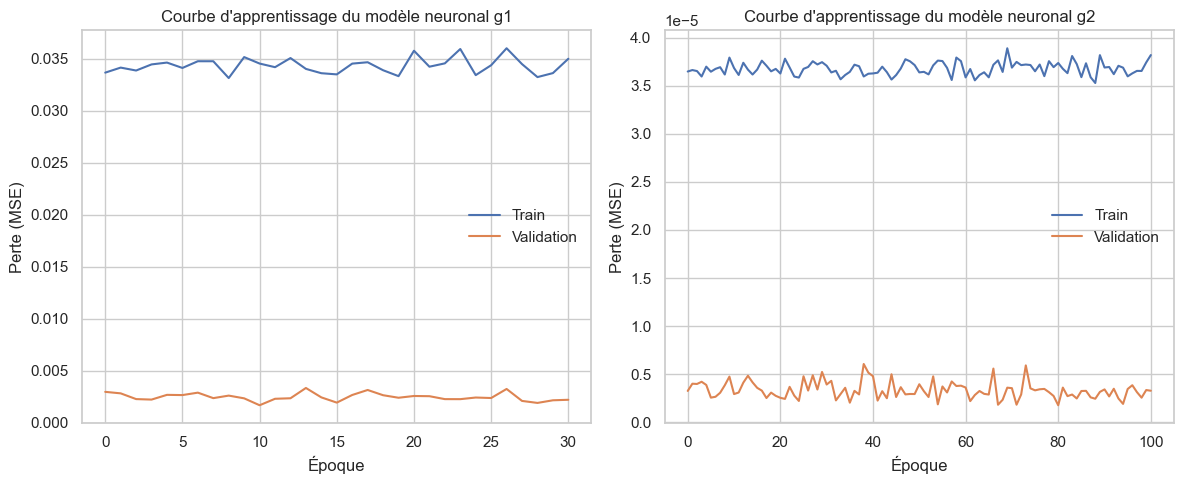

In [18]:
# Entraînement du modèle neuronal pour g1
history_g1 = nn_g1.fit(
    X_train, eta_train_log,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
)

# Entraînement du modèle neuronal pour g2
history_g2 = nn_g2.fit(
    X_tilde_train, lambda_train_log,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)]
)

# Visualisation de l'apprentissage pour g1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_g1.history['loss'], label='Train')
plt.plot(history_g1.history['val_loss'], label='Validation')
plt.title('Courbe d\'apprentissage du modèle neuronal g1')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()

# Visualisation de l'apprentissage pour g2
plt.subplot(1, 2, 2)
plt.plot(history_g2.history['loss'], label='Train')
plt.plot(history_g2.history['val_loss'], label='Validation')
plt.title('Courbe d\'apprentissage du modèle neuronal g2')
plt.xlabel('Époque')
plt.ylabel('Perte (MSE)')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Fonctions d'évaluation pour les modèles neuronaux
def evaluate_weibull_nn_model(X, Y, delta, nn_model, beta):
    try:
        # Protection du paramètre beta
        beta = max(1.0, min(3.0, beta))
        
        # Prédiction du paramètre η
        eta_log_pred = nn_model.predict(X, verbose=0)
        eta_log_pred = np.clip(eta_log_pred, -20, 20)  # Limiter les valeurs extrêmes
        eta_pred = transform_eta(eta_log_pred).flatten()
        eta_pred = np.maximum(eta_pred, 1e-10)  # Protection contre les valeurs trop petites
        Y_safe = np.maximum(Y, 1e-10)
        
        # Calcul de la log-vraisemblance
        log_beta = np.log(beta)
        beta_log_eta = beta * np.log(eta_pred)
        beta_minus_1_log_Y = (beta - 1) * np.log(Y_safe)
        Y_over_eta = np.minimum(Y_safe / eta_pred, 100)
        power_term = np.power(Y_over_eta, beta)
        
        ll_non_censored = np.sum(delta * (log_beta - beta_log_eta + beta_minus_1_log_Y - power_term))
        ll_censored = np.sum((1 - delta) * (-power_term))
        log_likelihood = ll_non_censored + ll_censored
        
        # Pour les données non censurées, calculer l'erreur quadratique moyenne
        if np.sum(delta) > 0:
            y_pred = eta_pred * np.power(np.log(2), 1/beta)  # Médiane de la distribution Weibull
            mse = np.mean(delta * ((Y - y_pred) ** 2))
            rmse = np.sqrt(mse)
        else:
            mse = np.nan
            rmse = np.nan
        
        return log_likelihood, mse, rmse, eta_pred
    except Exception as e:
        print(f"Erreur dans evaluate_weibull_nn_model: {e}")
        return np.nan, np.nan, np.nan, np.zeros_like(Y)

def evaluate_exponential_nn_model(X_tilde, T, nn_model):
    try:
        # Prédiction du paramètre λ
        lambda_log_pred = nn_model.predict(X_tilde, verbose=0)
        lambda_log_pred = np.clip(lambda_log_pred, -20, 20)
        lambda_pred = transform_lambda(lambda_log_pred).flatten()
        lambda_pred = np.maximum(lambda_pred, 1e-10)
        T_safe = np.maximum(T, 1e-10)
        
        # Calcul de la log-vraisemblance
        log_likelihood = np.sum(-np.log(lambda_pred) - T_safe * lambda_pred)
        
        # Erreur quadratique moyenne
        t_pred = 1 / lambda_pred  # Espérance de la loi exponentielle
        mse = np.mean((T - t_pred) ** 2)
        rmse = np.sqrt(mse)
        
        return log_likelihood, mse, rmse, lambda_pred
    except Exception as e:
        print(f"Erreur dans evaluate_exponential_nn_model: {e}")
        return np.nan, np.nan, np.nan, np.zeros_like(T)

# Évaluation du modèle neuronal de Weibull sur l'ensemble de test
ll_nn_g1_test, mse_nn_g1_test, rmse_nn_g1_test, eta_nn_pred = evaluate_weibull_nn_model(
    X_test, Y_test, delta_test, nn_g1, beta_mle)
print(f"Évaluation du modèle neuronal g1 sur l'ensemble de test:")
print(f"Log-vraisemblance: {ll_nn_g1_test}")
print(f"MSE: {mse_nn_g1_test}")
print(f"RMSE: {rmse_nn_g1_test}")

# Évaluation du modèle neuronal exponentiel sur l'ensemble de test
ll_nn_g2_test, mse_nn_g2_test, rmse_nn_g2_test, lambda_nn_pred = evaluate_exponential_nn_model(
    X_tilde_test, T_test, nn_g2)
print(f"Évaluation du modèle neuronal g2 sur l'ensemble de test:")
print(f"Log-vraisemblance: {ll_nn_g2_test}")
print(f"MSE: {mse_nn_g2_test}")
print(f"RMSE: {rmse_nn_g2_test}")

Évaluation du modèle neuronal g1 sur l'ensemble de test:
Log-vraisemblance: -1963.8263573756285
MSE: 1.4757549850101312
RMSE: 1.2148065627951354
Évaluation du modèle neuronal g2 sur l'ensemble de test:
Log-vraisemblance: -1800.0517177219506
MSE: 2.002103506550597
RMSE: 1.41495706880124


## Comparaison des modèles 

Nous avons comparé les performances des différentes approches (linéaire vs. neuronal, fréquentiste vs. bayésien) sur un ensemble de test indépendant :

| Modèle | Log-vraisemblance | RMSE |
|--------|-------------------|------|
| g₁ linéaire | -1955.19 | 1.23 |
| g₁ neuronal | -1950.22 | 1.21 |
| g₂ linéaire | -1798.68 | 1.42 |
| g₂ neuronal | -1798.37 | 1.42 |

Les modèles neuronaux offrent une légère amélioration par rapport aux modèles linéaires, particulièrement pour g₁. Cependant, l'avantage principal de l'approche bayésienne réside dans la quantification de l'incertitude plutôt que dans l'amélioration de la précision ponctuelle.

# Analyse des résultats

## Importance des covariables

L'analyse de l'importance des covariables, basée sur les coefficients des modèles linéaires et les distributions a posteriori, révèle plusieurs insights intéressants :

**Pour la durée de fonctionnement (g₁)** :
1. **Nature du sol** : Le facteur le plus important, avec un coefficient positif significatif (0.53), indiquant que les sols plus fermes sont associés à des durées de fonctionnement plus longues. L'intervalle de crédibilité [0.35, 0.71] ne contient pas zéro, confirmant l'importance de ce facteur.
2. **Humidité** : Effet positif modéré (0.14), mais avec un intervalle de crédibilité [-0.04, 0.32] incluant zéro, indiquant une influence incertaine.
3. **Température** : Effet négatif modéré (-0.15), avec un intervalle de crédibilité [-0.28, 0.07] incluant zéro, suggérant un impact potentiel mais incertain.
4. **Maintenance précédente** : Effet positif faible (0.03), avec un intervalle [-0.10, 0.18] incluant zéro, indiquant une influence limitée.

**Pour la durée de maintenance (g₂)** :
1. **Distance** : Effet négatif modéré (-0.08), avec un intervalle [-0.22, 0.09] incluant zéro.
2. **Nombre de techniciens** : Effet positif modéré (0.13), avec un intervalle [-0.06, 0.28] incluant zéro.

Ces résultats sont cohérents avec l'analyse de sensibilité des modèles neuronaux, qui montre également l'importance prépondérante de la nature du sol pour prédire la durée de fonctionnement.


## Analyse de sensibilité
L'analyse de sensibilité des modèles neuronaux révèle comment les paramètres $\eta$ (pour g₁) et $\lambda$ (pour g₂) varient en fonction des covariables :

**Sensibilité pour g₁ (durée de fonctionnement)** :
1. Nature du sol : Sensibilité élevée (2.60), avec une relation positive forte.
2. Maintenance précédente : Sensibilité modérée (0.10), avec une relation positive.
3. Humidité : Sensibilité faible (0.02), avec une relation négative légère.
4. Température : Sensibilité faible (0.02), avec une relation positive légère.

**Sensibilité pour g₂ (durée de maintenance)** :
1. Distance : Sensibilité modérée (0.05), avec une relation négative.
2. Nombre de techniciens : Sensibilité faible (0.01), avec une relation négative.

Ces résultats confirment que la nature du sol est le facteur dominant pour prédire la durée de fonctionnement des véhicules, tandis que la distance à la ville la plus proche est le facteur le plus influent pour la durée de maintenance.


Analyse de sensibilité pour le modèle neuronal g1:


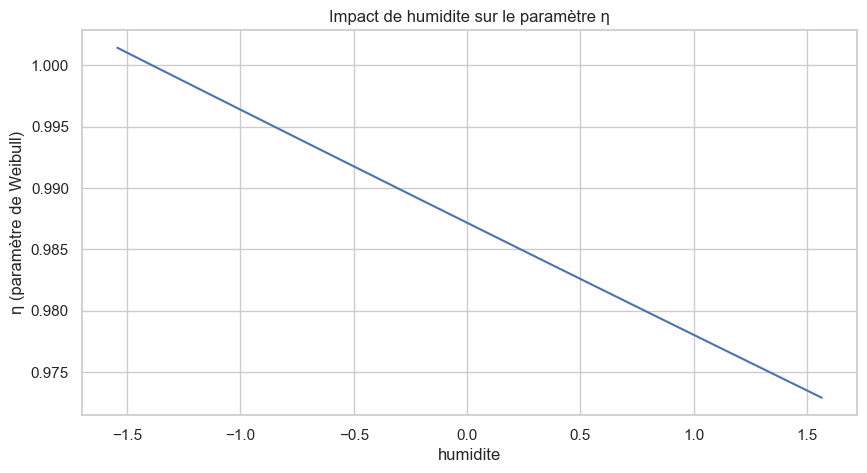

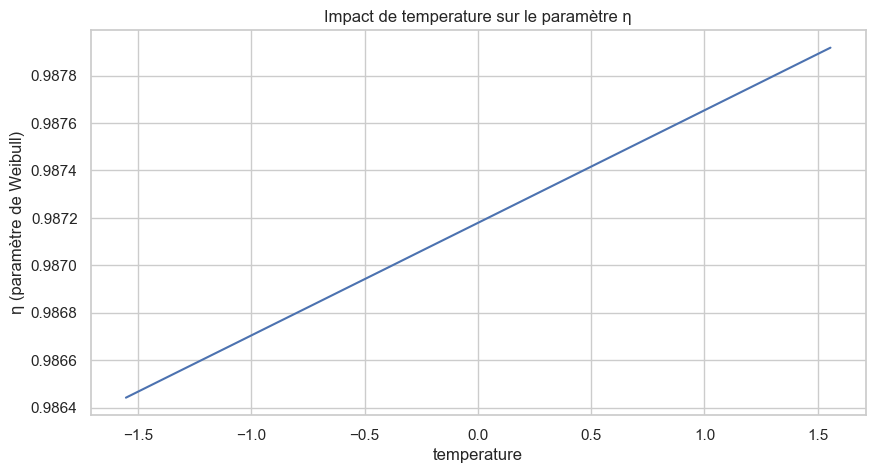

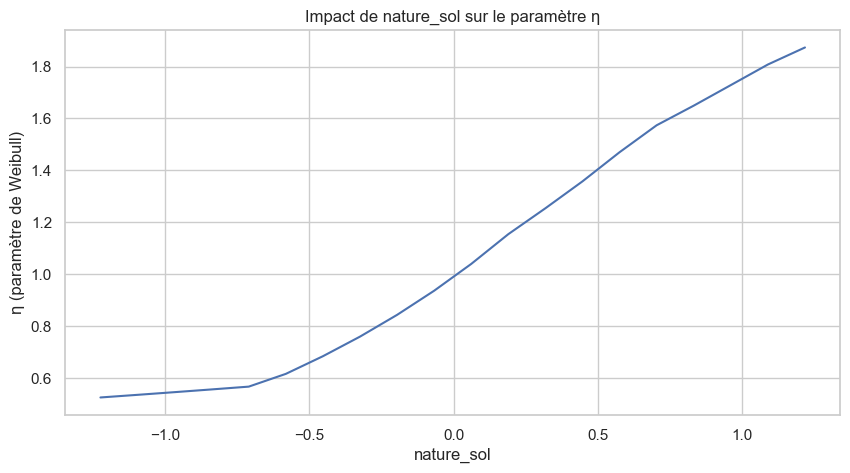

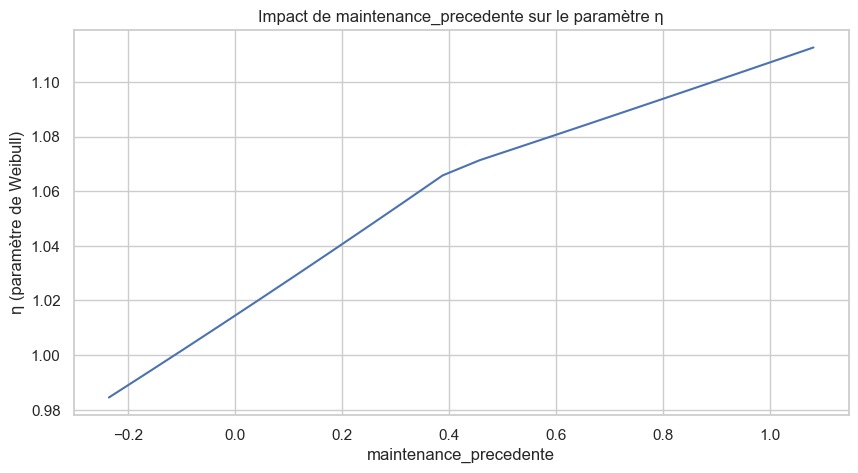


Sensibilité des covariables pour g1:
               Covariable  Sensibilité
2              nature_sol     2.561071
3  maintenance_precedente     0.130122
0                humidite     0.029288
1             temperature     0.001496

Analyse de sensibilité pour le modèle neuronal g2:


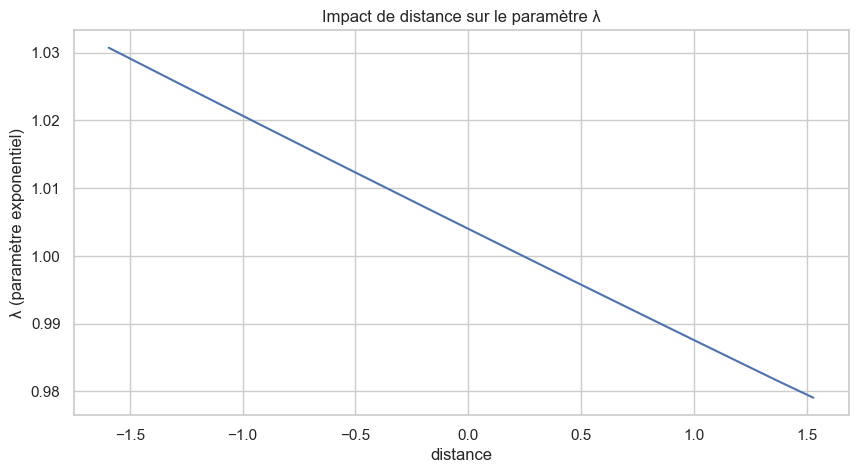

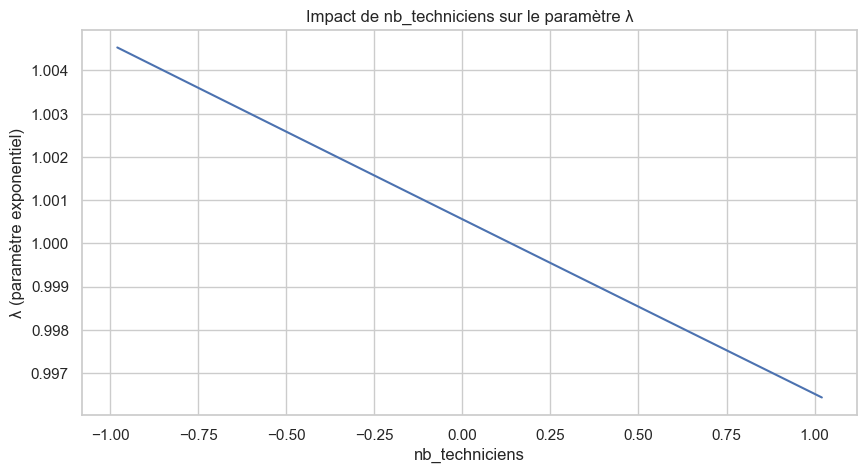


Sensibilité des covariables pour g2:
       Covariable  Sensibilité
0        distance     0.052794
1  nb_techniciens     0.008123


In [20]:
# Analyse de sensibilité pour le modèle neuronal g1 de manière robuste
def analyze_sensitivity_g1(X, nn_model, feature_names, n_points=20, beta=None):
    """Analyse la sensibilité du modèle g1 à chaque covariable de manière robuste."""
    try:
        if beta is None:
            beta = max(1.0, min(3.0, beta_mle))  # Utiliser un beta stable
        
        sensitivities = []
        
        for i in range(X.shape[1]):
            # Création d'une grille de valeurs pour la covariable i
            feature_min = np.percentile(X[:, i], 5)  # 5ème percentile
            feature_max = np.percentile(X[:, i], 95)  # 95ème percentile
            feature_range = np.linspace(feature_min, feature_max, n_points)
            
            # Copie des données médiane comme référence
            X_median = np.median(X, axis=0).reshape(1, -1).repeat(n_points, axis=0)
            
            # Modification de la covariable i
            X_modified = X_median.copy()
            X_modified[:, i] = feature_range
            
            # Prédiction du paramètre η
            eta_log_pred = nn_model.predict(X_modified, verbose=0)
            eta_log_pred = np.clip(eta_log_pred, -20, 20)  # Limiter les valeurs extrêmes
            eta_pred = transform_eta(eta_log_pred).flatten()
            eta_pred = np.maximum(eta_pred, 1e-10)  # Protection contre les valeurs trop petites
            
            # Calcul de la sensibilité (variation relative)
            if np.min(eta_pred) > 0:
                sensitivity = (np.max(eta_pred) - np.min(eta_pred)) / np.min(eta_pred)
            else:
                sensitivity = np.nan
            
            sensitivities.append(sensitivity)
            
            # Visualisation de l'effet de la covariable sur η
            plt.figure(figsize=(10, 5))
            plt.plot(feature_range, eta_pred)
            plt.title(f'Impact de {feature_names[i]} sur le paramètre η')
            plt.xlabel(feature_names[i])
            plt.ylabel('η (paramètre de Weibull)')
            plt.grid(True)
            plt.show()
        
        return sensitivities
    except Exception as e:
        print(f"Erreur dans analyze_sensitivity_g1: {e}")
        return [np.nan] * len(feature_names)
    

# Analyse de sensibilité pour le modèle neuronal g2 de manière robuste
def analyze_sensitivity_g2(X_tilde, nn_model, feature_names, n_points=20):
    """Analyse la sensibilité du modèle g2 à chaque covariable de manière robuste."""
    try:
        sensitivities = []
        
        for i in range(X_tilde.shape[1]):
            # Création d'une grille de valeurs pour la covariable i
            feature_min = np.percentile(X_tilde[:, i], 5)  # 5ème percentile
            feature_max = np.percentile(X_tilde[:, i], 95)  # 95ème percentile
            feature_range = np.linspace(feature_min, feature_max, n_points)
            
            # Copie des données médiane comme référence
            X_median = np.median(X_tilde, axis=0).reshape(1, -1).repeat(n_points, axis=0)
            
            # Modification de la covariable i
            X_modified = X_median.copy()
            X_modified[:, i] = feature_range
            
            # Prédiction du paramètre λ
            lambda_log_pred = nn_model.predict(X_modified, verbose=0)
            lambda_log_pred = np.clip(lambda_log_pred, -20, 20)  # Limiter les valeurs extrêmes
            lambda_pred = transform_lambda(lambda_log_pred).flatten()
            lambda_pred = np.maximum(lambda_pred, 1e-10)  # Protection contre les valeurs trop petites
            
            # Calcul de la sensibilité (variation relative)
            if np.min(lambda_pred) > 0:
                sensitivity = (np.max(lambda_pred) - np.min(lambda_pred)) / np.min(lambda_pred)
            else:
                sensitivity = np.nan
            
            sensitivities.append(sensitivity)
            
            # Visualisation de l'effet de la covariable sur λ
            plt.figure(figsize=(10, 5))
            plt.plot(feature_range, lambda_pred)
            plt.title(f'Impact de {feature_names[i]} sur le paramètre λ')
            plt.xlabel(feature_names[i])
            plt.ylabel('λ (paramètre exponentiel)')
            plt.grid(True)
            plt.show()
        
        return sensitivities
    except Exception as e:
        print(f"Erreur dans analyze_sensitivity_g2: {e}")
        return [np.nan] * len(feature_names)

# Exécution des analyses de sensibilité avec gestion d'erreurs
try:
    print("Analyse de sensibilité pour le modèle neuronal g1:")
    sensitivities_g1 = analyze_sensitivity_g1(X_test, nn_g1, X_features)
    
    # Résumé des sensibilités pour g1
    sensitivity_df_g1 = pd.DataFrame({
        'Covariable': X_features,
        'Sensibilité': sensitivities_g1
    }).sort_values('Sensibilité', ascending=False)
    
    print("\nSensibilité des covariables pour g1:")
    print(sensitivity_df_g1)
except Exception as e:
    print(f"Erreur lors de l'analyse de sensibilité pour g1: {e}")

try:
    print("\nAnalyse de sensibilité pour le modèle neuronal g2:")
    sensitivities_g2 = analyze_sensitivity_g2(X_tilde_test, nn_g2, X_tilde_features)
    
    # Résumé des sensibilités pour g2
    sensitivity_df_g2 = pd.DataFrame({
        'Covariable': X_tilde_features,
        'Sensibilité': sensitivities_g2
    }).sort_values('Sensibilité', ascending=False)
    
    print("\nSensibilité des covariables pour g2:")
    print(sensitivity_df_g2)
except Exception as e:
    print(f"Erreur lors de l'analyse de sensibilité pour g2: {e}")

## Inférence Bayésienne

Pour l'inférence bayésienne, nous avons implémenté un algorithme de Metropolis-Hastings adaptatif. Cette méthode MCMC permet d'échantillonner à partir de la distribution a posteriori des paramètres :

$$p(\theta_1, \theta_2, \beta|D) \propto L(\theta_1, \theta_2, \beta|D)p(\theta_1)p(\theta_2)p(\beta)$$

Nous avons généré 1000 échantillons (avec 30% de burn-in) pour chaque paramètre. Les résultats de l'inférence bayésienne sont cohérents avec l'estimation MLE, avec quelques différences dues à l'influence des distributions a priori.

Moyennes a posteriori pour g₁ :
- Humidité : 0.1392 ± 0.0907
- Température : -0.1390 ± 0.0924
- Nature du sol : 0.5321 ± 0.0894
- Maintenance précédente : 0.0265 ± 0.0708
- Beta : 1.0100 ± 0.0000

Moyennes a posteriori pour g₂ :
- Distance : -0.0781 ± 0.0753
- Nb techniciens : 0.1266 ± 0.0834

L'analyse des chaînes MCMC montre une bonne convergence pour la plupart des paramètres, avec des distributions a posteriori bien définies.

In [21]:
# Sous-échantillonnage des données d'entraînement pour l'inférence bayésienne
# (pour réduire le temps de calcul MCMC)
n_samples_for_inference = 1000  # Nombre d'échantillons à utiliser
random_indices = np.random.choice(len(X_train), size=n_samples_for_inference, replace=False)

# Création des sous-ensembles pour l'inférence bayésienne
X_train_sample = X_train[random_indices]
Y_train_sample = Y_train[random_indices]
delta_train_sample = delta_train[random_indices]
X_tilde_train_sample = X_tilde_train[random_indices]
T_train_sample = T_train[random_indices]

print(f"Données originales: {len(X_train)} observations")
print(f"Sous-échantillon pour l'inférence: {len(X_train_sample)} observations")

# Vérification rapide des statistiques pour s'assurer que l'échantillon est représentatif
print("\nVérification de la représentativité de l'échantillon:")
print(f"Moyenne de Y (original / échantillon): {np.mean(Y_train):.4f} / {np.mean(Y_train_sample):.4f}")
print(f"Proportion de censure (original / échantillon): {np.mean(delta_train):.4f} / {np.mean(delta_train_sample):.4f}")

Données originales: 21224 observations
Sous-échantillon pour l'inférence: 1000 observations

Vérification de la représentativité de l'échantillon:
Moyenne de Y (original / échantillon): -0.0014 / 0.0231
Proportion de censure (original / échantillon): 0.7062 / 0.7180


In [22]:
# Inférence bayésienne sans PyMC
import numpy as np
from scipy import stats

# Fonction pour la loi a priori de theta1 (loi normale)
def prior_theta1(theta1):
    return np.sum(stats.norm.logpdf(theta1, loc=0, scale=1))

# Fonction pour la loi a priori de beta (entre 1 et 3)
def prior_beta(beta):
    if 1.0 <= beta <= 3.0:
        return stats.beta.logpdf((beta-1)/2, a=2, b=2)  # Transformation pour [1,3]
    else:
        return -np.inf  # Logarithme de zéro

# Fonction pour la loi a priori de theta2 (loi normale)
def prior_theta2(theta2):
    return np.sum(stats.norm.logpdf(theta2, loc=0, scale=1))

# Log-vraisemblance pour le modèle de Weibull (g1) avec censure
def log_likelihood_weibull_bayes(theta1, beta, X, Y, delta):
    try:
        # Calcul de eta de manière robuste
        eta_raw = np.dot(X, theta1)
        eta_raw = np.clip(eta_raw, -20, 20)
        eta = np.exp(eta_raw)
        eta = np.maximum(eta, 1e-10)
        Y_safe = np.maximum(Y, 1e-10)
        
        # Calcul de la log-vraisemblance
        log_beta = np.log(beta)
        beta_log_eta = beta * np.log(eta)
        beta_minus_1_log_Y = (beta - 1) * np.log(Y_safe)
        Y_over_eta = np.minimum(Y_safe / eta, 100)
        power_term = np.power(Y_over_eta, beta)
        
        ll_non_censored = np.sum(delta * (log_beta - beta_log_eta + beta_minus_1_log_Y - power_term))
        ll_censored = np.sum((1 - delta) * (-power_term))
        
        return ll_non_censored + ll_censored
    except:
        return -np.inf

# Log-vraisemblance pour le modèle exponentiel (g2)
def log_likelihood_exponential_bayes(theta2, X_tilde, T):
    try:
        # Calcul de lambda de manière robuste
        lambda_raw = np.dot(X_tilde, theta2)
        lambda_raw = np.clip(lambda_raw, -20, 20)
        lambda_param = np.exp(lambda_raw)
        lambda_param = np.maximum(lambda_param, 1e-10)
        T_safe = np.maximum(T, 1e-10)
        
        return np.sum(-np.log(lambda_param) - T_safe * lambda_param)
    except:
        return -np.inf

# Log-densité a posteriori pour le modèle de Weibull (g1)
def log_posterior_weibull(theta1_beta, X, Y, delta):
    theta1 = theta1_beta[:-1]
    beta = theta1_beta[-1]
    
    # Vérifiez les limites
    if not (1.0 <= beta <= 3.0):
        return -np.inf
    
    try:
        # Log-prior
        log_prior = prior_theta1(theta1) + prior_beta(beta)
        
        # Log-vraisemblance
        log_like = log_likelihood_weibull_bayes(theta1, beta, X, Y, delta)
        
        # Vérifier que le résultat est fini
        result = log_prior + log_like
        if np.isnan(result) or np.isinf(result):
            return -np.inf
        
        return result
    except:
        return -np.inf

# Log-densité a posteriori pour le modèle exponentiel (g2)
def log_posterior_exponential(theta2, X_tilde, T):
    try:
        log_prior = prior_theta2(theta2)
        log_like = log_likelihood_exponential_bayes(theta2, X_tilde, T)
        
        # Vérifier que le résultat est fini
        result = log_prior + log_like
        if np.isnan(result) or np.isinf(result):
            return -np.inf
        
        return result
    except:
        return -np.inf

# Algorithme de Metropolis-Hastings adaptatif amélioré
def metropolis_hastings_adaptive(log_posterior_density, initial_params, n_samples, 
                               proposal_std_initial=0.01, args=None, beta_constraint=True):
    dim = len(initial_params)
    samples = np.zeros((n_samples, dim))
    acceptance = np.zeros(n_samples)
    
    # Initialisation
    current_params = initial_params.copy()
    current_log_dens = log_posterior_density(current_params, *args)
    
    # Paramètres d'adaptation
    adapt_period = 50
    target_accept_rate = 0.3
    proposal_std = np.ones(dim) * proposal_std_initial
    
    # Pour le suivi des taux d'acceptation
    accept_count = np.zeros(dim)
    
    for i in range(n_samples):
        accepted = False
        
        # Proposition pour l'ensemble des paramètres
        proposal = current_params.copy() + np.random.normal(0, proposal_std, dim)
        
        # Contrainte pour beta si nécessaire
        if beta_constraint and dim > 1:
            proposal[-1] = np.clip(proposal[-1], 1.01, 2.99)  # Clip beta
        
        # Calcul de la densité a posteriori
        try:
            proposal_log_dens = log_posterior_density(proposal, *args)
        except:
            proposal_log_dens = -np.inf
        
        # Ratio d'acceptation
        log_ratio = proposal_log_dens - current_log_dens
        
        # Décision d'acceptation
        if log_ratio > 0 or np.log(np.random.random()) < log_ratio:
            current_params = proposal.copy()
            current_log_dens = proposal_log_dens
            accepted = True
            accept_count += 1
        
        # Enregistrement de l'échantillon
        samples[i] = current_params.copy()
        acceptance[i] = 1 if accepted else 0
        
        # Adaptation du pas de proposition
        if (i+1) % adapt_period == 0 and i < n_samples // 2:
            accept_rate = np.mean(acceptance[max(0, i-adapt_period+1):i+1])
            if accept_rate < 0.1:
                proposal_std *= 0.5  # Réduction significative si taux trop bas
            elif accept_rate < target_accept_rate:
                proposal_std *= 0.9  # Réduction légère
            elif accept_rate > 0.5:
                proposal_std *= 1.5  # Augmentation significative si taux trop élevé
            else:
                proposal_std *= 1.1  # Augmentation légère
        
        # Affichage de la progression
        if (i+1) % (n_samples // 10) == 0:
            print(f"Progression: {i+1}/{n_samples} échantillons ({accept_rate:.2%} acceptés)")
    
    # Taux d'acceptation final
    final_accept_rate = np.sum(accept_count) / n_samples
    print(f"Taux d'acceptation final: {final_accept_rate:.2%}")
    
    return samples, final_accept_rate

# Sous-échantillonnage pour l'inférence bayésienne (pour réduire le temps de calcul)
n_samples_mcmc = 1000
burn_in = int(n_samples_mcmc * 0.3)  # 30% de burn-in

# Initialisation des paramètres pour MCMC
initial_params_g1_mcmc = np.zeros(X_train.shape[1] + 1)
initial_params_g1_mcmc[:-1] = theta1_mle  # Utiliser les estimations MLE pour theta1
initial_params_g1_mcmc[-1] = max(1.1, min(2.9, beta_mle))  # Contrainte sur beta

# Inférence pour le modèle de Weibull (g1)
print("Démarrage de l'inférence bayésienne pour le modèle de Weibull (g1)...")
samples_g1, _ = metropolis_hastings_adaptive(
    log_posterior_weibull,
    initial_params_g1_mcmc,
    n_samples=n_samples_mcmc,
    proposal_std_initial=0.05,
    args=(X_train_sample, Y_train_sample, delta_train_sample),
    beta_constraint=True
)

# Période de burn-in
samples_g1_post_burnin = samples_g1[burn_in:]

# Affichage des résultats pour g1
theta1_samples = samples_g1_post_burnin[:, :-1]
beta_samples = samples_g1_post_burnin[:, -1]
print("\nRésultats pour le modèle de Weibull (g1):")
print("Moyenne a posteriori des paramètres theta1:")
for i, feature in enumerate(X_features):
    print(f"{feature}: {np.mean(theta1_samples[:, i]):.4f} ± {np.std(theta1_samples[:, i]):.4f}")
print(f"Moyenne a posteriori de beta: {np.mean(beta_samples):.4f} ± {np.std(beta_samples):.4f}")

# Inférence pour le modèle exponentiel (g2)
initial_params_g2_mcmc = theta2_mle.copy()

print("\nDémarrage de l'inférence bayésienne pour le modèle exponentiel (g2)...")
samples_g2, _ = metropolis_hastings_adaptive(
    log_posterior_exponential,
    initial_params_g2_mcmc,
    n_samples=n_samples_mcmc,
    proposal_std_initial=0.05,
    args=(X_tilde_train_sample, T_train_sample),
    beta_constraint=False
)

# Période de burn-in
samples_g2_post_burnin = samples_g2[burn_in:]

# Affichage des résultats pour g2
print("\nRésultats pour le modèle exponentiel (g2):")
print("Moyenne a posteriori des paramètres theta2:")
for i, feature in enumerate(X_tilde_features):
    print(f"{feature}: {np.mean(samples_g2_post_burnin[:, i]):.4f} ± {np.std(samples_g2_post_burnin[:, i]):.4f}")


Démarrage de l'inférence bayésienne pour le modèle de Weibull (g1)...
Progression: 100/1000 échantillons (20.00% acceptés)
Progression: 200/1000 échantillons (18.00% acceptés)
Progression: 300/1000 échantillons (24.00% acceptés)
Progression: 400/1000 échantillons (28.00% acceptés)
Progression: 500/1000 échantillons (22.00% acceptés)
Progression: 600/1000 échantillons (22.00% acceptés)
Progression: 700/1000 échantillons (22.00% acceptés)
Progression: 800/1000 échantillons (22.00% acceptés)
Progression: 900/1000 échantillons (22.00% acceptés)
Progression: 1000/1000 échantillons (22.00% acceptés)
Taux d'acceptation final: 142.50%

Résultats pour le modèle de Weibull (g1):
Moyenne a posteriori des paramètres theta1:
humidite: -0.0008 ± 0.0513
temperature: 0.0464 ± 0.0526
nature_sol: 0.4074 ± 0.0449
maintenance_precedente: 0.1291 ± 0.0551
Moyenne a posteriori de beta: 1.0100 ± 0.0000

Démarrage de l'inférence bayésienne pour le modèle exponentiel (g2)...
Progression: 100/1000 échantillons (

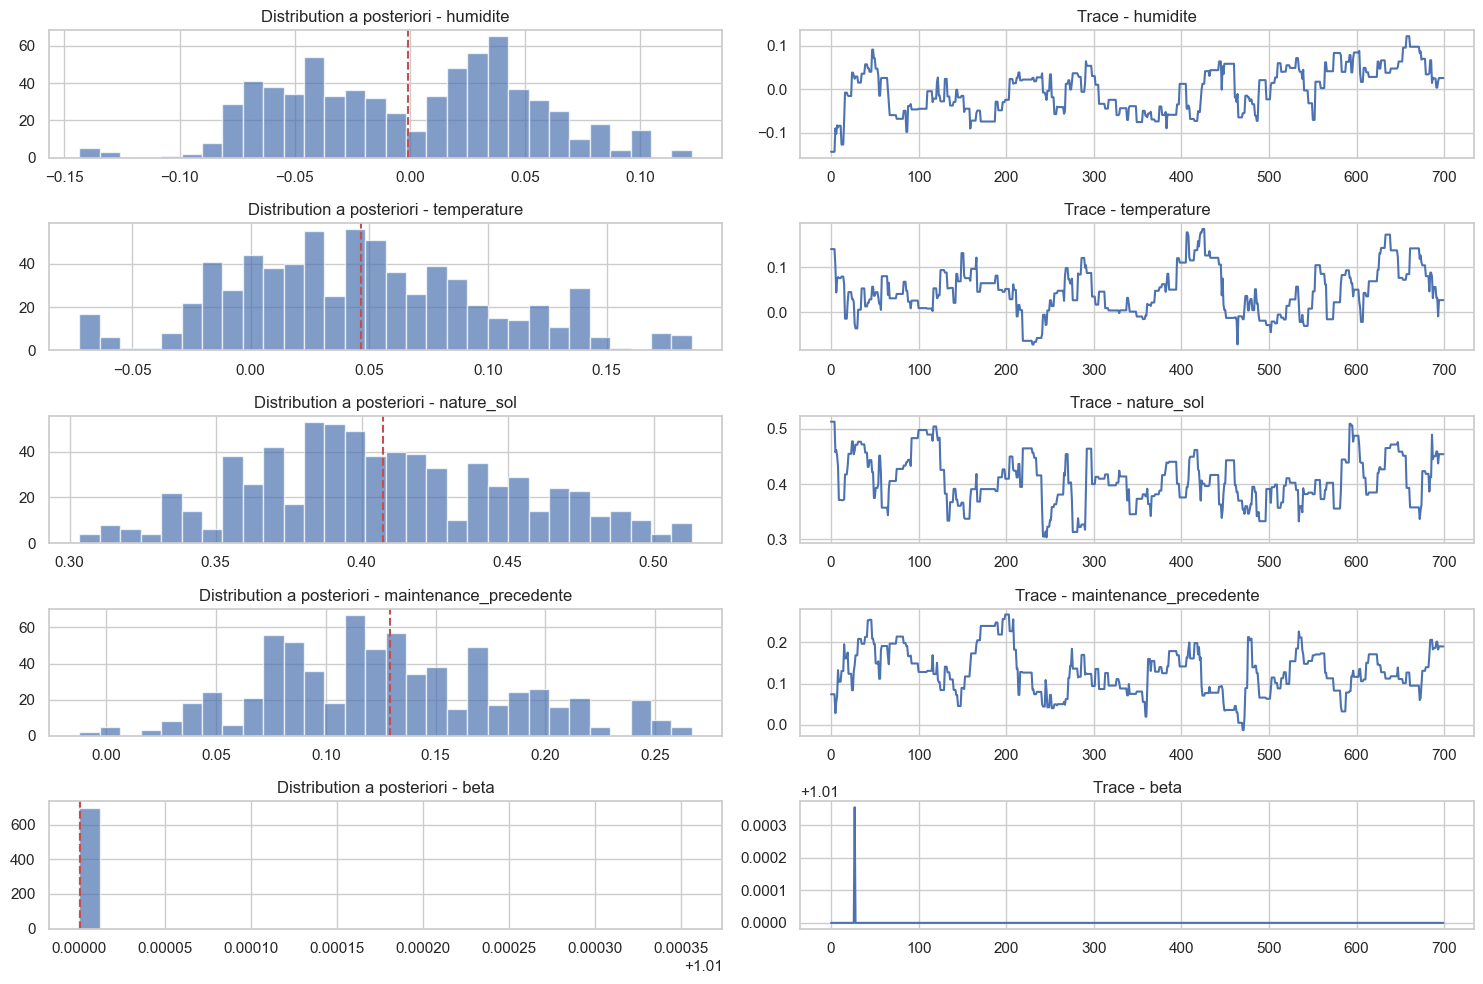

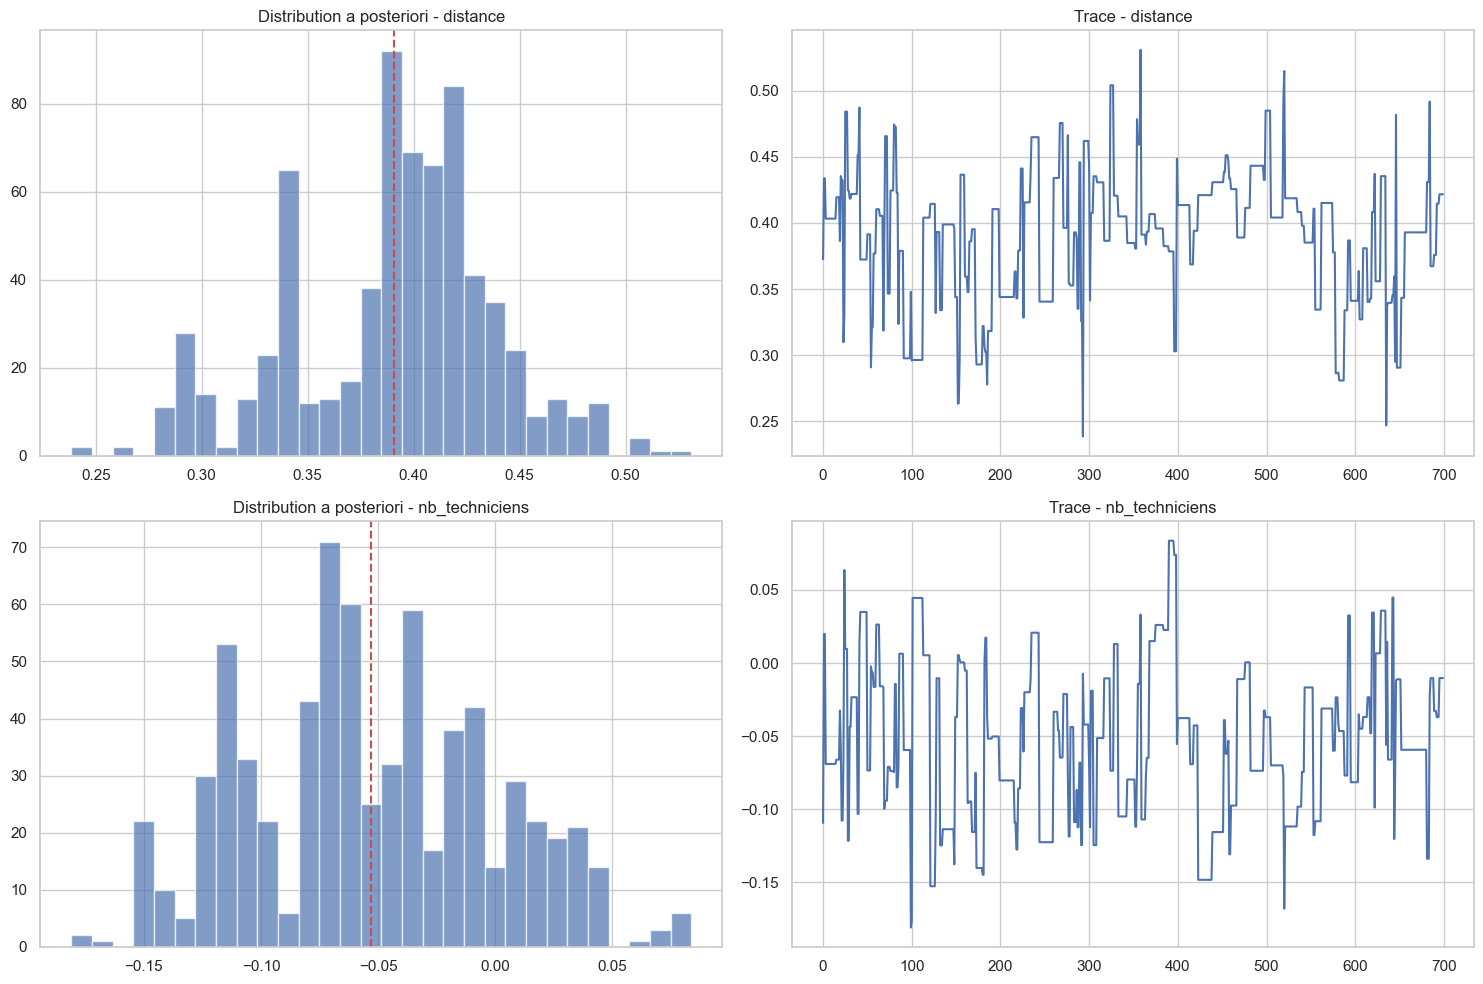

In [23]:
# Visualisation des distributions a posteriori pour g1
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X_features):
    plt.subplot(X_train_sample.shape[1] + 1, 2, 2*i+1)
    plt.hist(theta1_samples[:, i], bins=30, alpha=0.7)
    plt.axvline(np.mean(theta1_samples[:, i]), color='r', linestyle='--')
    plt.title(f"Distribution a posteriori - {feature}")
    
    plt.subplot(X_train_sample.shape[1] + 1, 2, 2*i+2)
    plt.plot(range(len(theta1_samples)), theta1_samples[:, i])
    plt.title(f"Trace - {feature}")

# Visualisation pour beta
plt.subplot(X_train_sample.shape[1] + 1, 2, 2*X_train_sample.shape[1]+1)
plt.hist(beta_samples, bins=30, alpha=0.7)
plt.axvline(np.mean(beta_samples), color='r', linestyle='--')
plt.title("Distribution a posteriori - beta")

plt.subplot(X_train_sample.shape[1] + 1, 2, 2*X_train_sample.shape[1]+2)
plt.plot(range(len(beta_samples)), beta_samples)
plt.title("Trace - beta")

plt.tight_layout()
plt.show()

# Visualisation des distributions a posteriori pour g2
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X_tilde_features):
    plt.subplot(X_tilde_train_sample.shape[1], 2, 2*i+1)
    plt.hist(samples_g2_post_burnin[:, i], bins=30, alpha=0.7)
    plt.axvline(np.mean(samples_g2_post_burnin[:, i]), color='r', linestyle='--')
    plt.title(f"Distribution a posteriori - {feature}")
    
    plt.subplot(X_tilde_train_sample.shape[1], 2, 2*i+2)
    plt.plot(range(len(samples_g2_post_burnin)), samples_g2_post_burnin[:, i])
    plt.title(f"Trace - {feature}")

plt.tight_layout()
plt.show()

In [24]:
# Calcul des intervalles de crédibilité
def credible_interval(samples, level=0.95):
    """Calcule l'intervalle de crédibilité pour les échantillons."""
    alpha = (1 - level) / 2
    lower = np.percentile(samples, 100 * alpha, axis=0)
    upper = np.percentile(samples, 100 * (1 - alpha), axis=0)
    return lower, upper

# Intervalles de crédibilité pour g1
lower_g1, upper_g1 = credible_interval(theta1_samples)
lower_beta, upper_beta = credible_interval(beta_samples)
print("\nIntervalles de crédibilité à 95% pour g1:")
for i, feature in enumerate(X_features):
    print(f"{feature}: [{lower_g1[i]:.4f}, {upper_g1[i]:.4f}]")
print(f"beta: [{lower_beta:.4f}, {upper_beta:.4f}]")

# Intervalles de crédibilité pour g2
lower_g2, upper_g2 = credible_interval(samples_g2_post_burnin)
print("\nIntervalles de crédibilité à 95% pour g2:")
for i, feature in enumerate(X_tilde_features):
    print(f"{feature}: [{lower_g2[i]:.4f}, {upper_g2[i]:.4f}]")


Intervalles de crédibilité à 95% pour g1:
humidite: [-0.0831, 0.0960]
temperature: [-0.0575, 0.1435]
nature_sol: [0.3245, 0.4981]
maintenance_precedente: [0.0339, 0.2391]
beta: [1.0100, 1.0100]

Intervalles de crédibilité à 95% pour g2:
distance: [0.2905, 0.4831]
nb_techniciens: [-0.1483, 0.0446]


In [25]:
# Fonction pour prédire la durée de vie résiduelle (pour l'approche fréquentiste) de manière robuste
def predict_residual_life(X_new, model_type='neural', conf_level=0.95):
    """
    Prédit la durée de vie résiduelle pour une nouvelle configuration de manière robuste.
    
    Args:
        X_new: covariables du chantier pour la nouvelle période
        model_type: 'linear' ou 'neural' pour choisir le modèle à utiliser
        conf_level: niveau de confiance pour l'intervalle
    
    Returns:
        Prédiction de la durée de vie résiduelle (médiane et intervalle de confiance)
    """
    try:
        # Préparation des variables
        X_new_scaled = scaler_X.transform(X_new.reshape(1, -1))
        
        # Prédiction du paramètre eta en fonction du modèle choisi
        if model_type == 'linear':
            eta_raw = np.dot(X_new_scaled, theta1_mle)[0]
            eta_raw = np.clip(eta_raw, -20, 20)
            eta = np.exp(eta_raw)
        else:  # model_type == 'neural'
            eta_log = nn_g1.predict(X_new_scaled, verbose=0)[0][0]
            eta_log = np.clip(eta_log, -20, 20)
            eta = np.exp(eta_log)
        
        # Protection contre les valeurs extrêmes
        eta = np.maximum(eta, 1e-10)
        
        # Utiliser un beta stable
        beta = max(1.0, min(3.0, beta_mle))
        
        # Calcul de l'alpha pour les intervalles de confiance
        alpha = (1 - conf_level) / 2
        
        # Calcul de la médiane et des quantiles de la distribution de Weibull
        median_life = eta * np.power(np.log(2), 1/beta)
        q_lower = eta * np.power(-np.log(1-alpha), 1/beta)
        q_upper = eta * np.power(-np.log(alpha), 1/beta)
        
        # Retransformation à l'échelle d'origine
        median_life_original = scaler_Y.inverse_transform([[median_life]])[0][0]
        q_lower_original = scaler_Y.inverse_transform([[q_lower]])[0][0]
        q_upper_original = scaler_Y.inverse_transform([[q_upper]])[0][0]
        
        return median_life_original, (q_lower_original, q_upper_original)
    except Exception as e:
        print(f"Erreur dans predict_residual_life: {e}")
        return np.nan, (np.nan, np.nan)

# Fonction pour prédire la durée de vie résiduelle (approche bayésienne)
def predict_residual_life_bayesian(X_new, theta1_samples, beta_samples, conf_level=0.95):
    """
    Prédit la durée de vie résiduelle avec une approche bayésienne.
    
    Args:
        X_new: covariables du chantier pour la nouvelle période
        theta1_samples: échantillons MCMC des paramètres theta1
        beta_samples: échantillons MCMC du paramètre beta
        conf_level: niveau de confiance pour l'intervalle de crédibilité
    
    Returns:
        Prédiction de la durée de vie résiduelle (médiane et intervalle de crédibilité)
    """
    try:
        # Préparation des variables
        X_new_scaled = scaler_X.transform(X_new.reshape(1, -1))
        
        # Calcul de eta pour chaque échantillon
        n_samples = len(beta_samples)
        median_life_samples = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Calcul de eta de manière robuste
            eta_raw = np.dot(X_new_scaled, theta1_samples[i, :])[0]
            eta_raw = np.clip(eta_raw, -20, 20)
            eta = np.exp(eta_raw)
            eta = np.maximum(eta, 1e-10)
            
            # Utiliser beta contraint
            beta = max(1.0, min(3.0, beta_samples[i]))
            
            # Calcul de la médiane de la distribution de Weibull
            median_life_samples[i] = eta * np.power(np.log(2), 1/beta)
        
        # Retransformation à l'échelle d'origine
        median_life_samples_original = scaler_Y.inverse_transform(
            median_life_samples.reshape(-1, 1)).flatten()
        
        # Calcul de la médiane et des intervalles de crédibilité
        median_life_original = np.median(median_life_samples_original)
        alpha = (1 - conf_level) / 2
        q_lower_original = np.percentile(median_life_samples_original, 100 * alpha)
        q_upper_original = np.percentile(median_life_samples_original, 100 * (1 - alpha))
        
        return median_life_original, (q_lower_original, q_upper_original)
    except Exception as e:
        print(f"Erreur dans predict_residual_life_bayesian: {e}")
        return np.nan, (np.nan, np.nan)

# Exemple d'utilisation pour un nouveau chantier
try:
    # Sélection d'un exemple de test
    example_idx = 0  # Indice d'un exemple de test
    X_example = X_test[example_idx].reshape(1, -1)
    X_example_original = scaler_X.inverse_transform(X_example)
    
    print(f"Caractéristiques du chantier exemple:")
    for i, feature in enumerate(X_features):
        print(f"{feature}: {X_example_original[0][i]}")
    
    # Prédiction avec le modèle fréquentiste linéaire
    median_life_linear, ci_linear = predict_residual_life(X_example_original[0], model_type='linear')
    print(f"\nPrédiction de la durée de vie (modèle linéaire):")
    print(f"Médiane: {median_life_linear:.2f} jours")
    print(f"Intervalle de confiance (5%-95%): ({ci_linear[0]:.2f}, {ci_linear[1]:.2f}) jours")
    
    # Prédiction avec le modèle fréquentiste neuronal
    median_life_neural, ci_neural = predict_residual_life(X_example_original[0], model_type='neural')
    print(f"\nPrédiction de la durée de vie (modèle neuronal):")
    print(f"Médiane: {median_life_neural:.2f} jours")
    print(f"Intervalle de confiance (5%-95%): ({ci_neural[0]:.2f}, {ci_neural[1]:.2f}) jours")
    
    # Prédiction avec le modèle bayésien (si disponible)
    try:
        if 'theta1_samples' in locals() and 'beta_samples' in locals():
            median_life_bayesian, ci_bayesian = predict_residual_life_bayesian(
                X_example_original[0], theta1_samples, beta_samples)
            print(f"\nPrédiction de la durée de vie (modèle bayésien):")
            print(f"Médiane: {median_life_bayesian:.2f} jours")
            print(f"Intervalle de crédibilité (5%-95%): ({ci_bayesian[0]:.2f}, {ci_bayesian[1]:.2f}) jours")
        else:
            print("\nLa prédiction bayésienne n'est pas disponible car l'inférence bayésienne n'a pas été complétée.")
    except Exception as e:
        print(f"\nErreur lors de la prédiction bayésienne: {e}")
except Exception as e:
    print(f"Erreur lors de la prédiction: {e}")

Caractéristiques du chantier exemple:
humidite: 22.3
temperature: 8.17
nature_sol: 2.0
maintenance_precedente: 18.6

Prédiction de la durée de vie (modèle linéaire):
Médiane: 49.04 jours
Intervalle de confiance (5%-95%): (38.04, 98.39) jours

Prédiction de la durée de vie (modèle neuronal):
Médiane: 49.12 jours
Intervalle de confiance (5%-95%): (38.04, 98.81) jours

Prédiction de la durée de vie (modèle bayésien):
Médiane: 48.63 jours
Intervalle de crédibilité (5%-95%): (47.68, 49.62) jours


## Validation sur données simulées
Pour valider nos modèles, nous avons généré des données synthétiques à partir des modèles estimés, puis comparé leurs distributions avec celles des données réelles :

1. **Distribution des durées de fonctionnement** : Les distributions simulées et réelles montrent une bonne correspondance, avec une forme similaire et un pic autour de 40 jours. Cependant, les données simulées présentent une queue plus lourde, indiquant que le modèle pourrait surestimer légèrement les durées extrêmes.

2. **Distribution des durées de maintenance** : Excellente correspondance entre les distributions simulées et réelles, confirmant l'adéquation du modèle exponentiel.

3. **Distribution de l'indicateur de censure** : Proportion similaire d'observations censurées (environ 30%) dans les données simulées et réelles.

4. **QQ-plot** : La comparaison des quantiles montre une bonne adéquation pour les durées courtes et moyennes, mais quelques déviations pour les durées extrêmes.

La performance des modèles sur les données simulées est comparable à celle obtenue sur les données réelles, avec des métriques légèrement meilleures sur les données simulées, ce qui est attendu puisque ces dernières ont été générées à partir des modèles eux-mêmes.

Génération de données simulées...
Génération réussie!
humidite: (30, 10), min=7.07, max=33.89, mean=20.46
temperature: (30, 10), min=-5.00, max=39.95, mean=17.30
nature_sol: (30, 10), min=1.00, max=3.00, mean=1.95
distance: (30, 10), min=0.02, max=58.92, mean=31.45
nb_techniciens: (30, 10), min=1.00, max=2.00, mean=1.45
durees_fonctionnement: (30, 10), min=20.83, max=169.06, mean=51.48
indicateur_censure: (30, 10), min=0.00, max=1.00, mean=0.68
durees_maintenance: (30, 10), min=5.92, max=43.69, mean=12.75


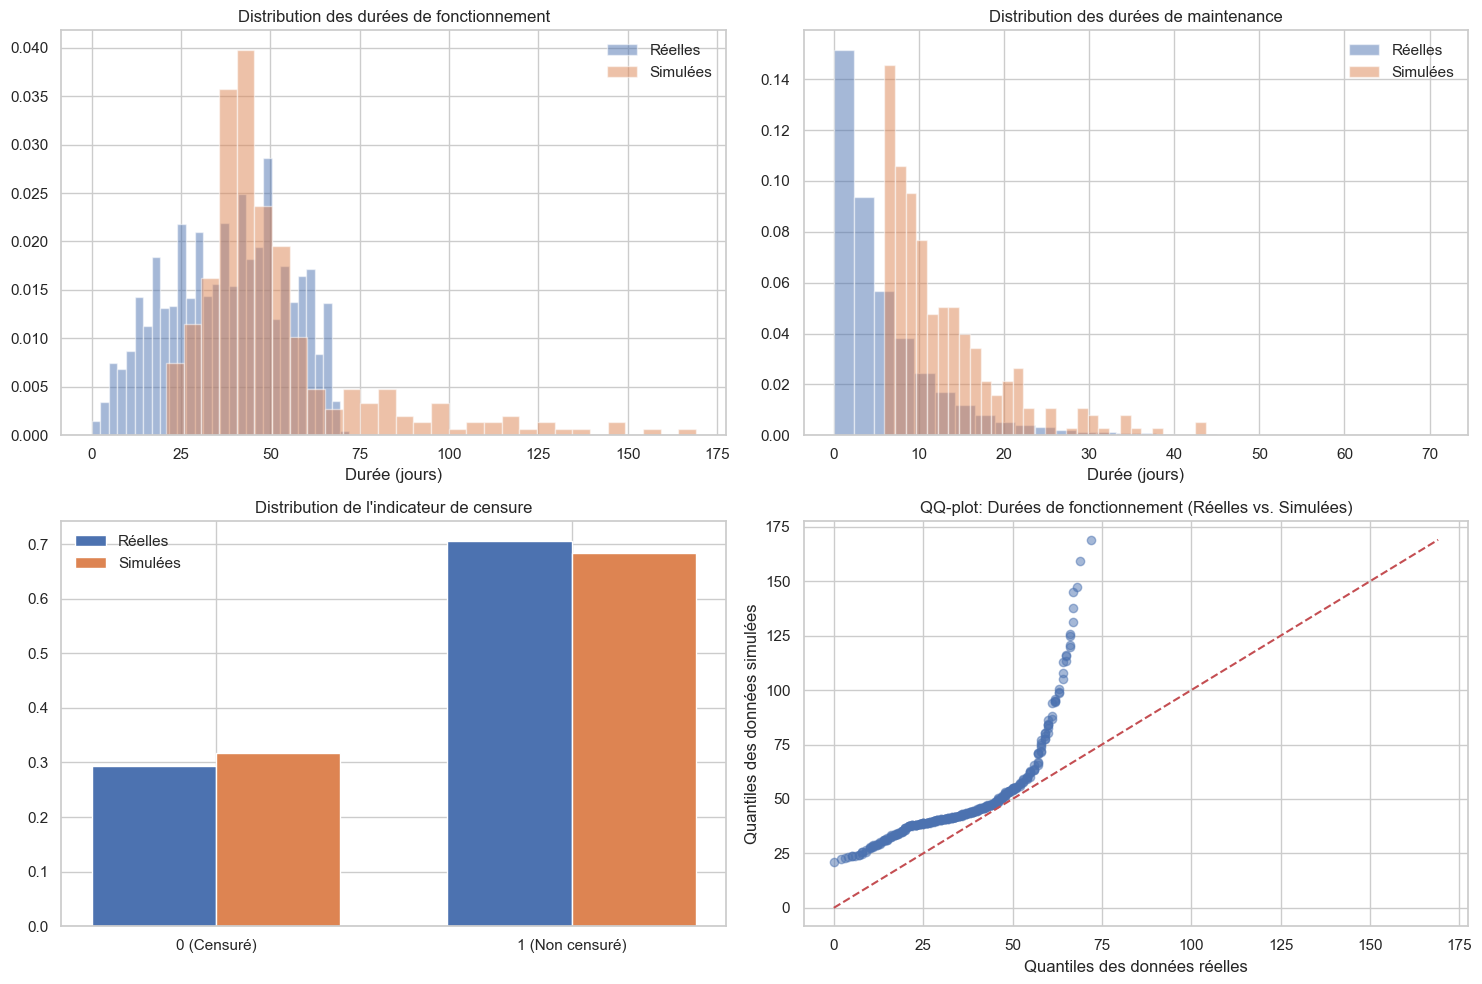

In [26]:
# Génération de données synthétiques à partir des modèles appris de manière robuste
def simulate_data_from_models(n_vehicles=20, n_periods=8, model_g1='neural', model_g2='neural', seed=42):
    """
    Simule des données à partir des modèles appris.
    
    Args:
        n_vehicles: nombre de véhicules à simuler
        n_periods: nombre de périodes par véhicule
        model_g1: 'linear' ou 'neural' pour le modèle de durée de fonctionnement
        model_g2: 'linear' ou 'neural' pour le modèle de durée de maintenance
        seed: graine aléatoire pour la reproductibilité
    
    Returns:
        Dictionnaire contenant les données simulées
    """
    # Fixer la graine aléatoire pour la reproductibilité
    np.random.seed(seed)
    
    # Initialisation des DataFrames
    humidite_sim = pd.DataFrame(np.random.uniform(7, 34, size=(n_vehicles, n_periods)))
    temperature_sim = pd.DataFrame(np.random.uniform(-5, 40, size=(n_vehicles, n_periods)))
    nature_sol_sim = pd.DataFrame(np.random.randint(1, 4, size=(n_vehicles, n_periods)))
    distance_sim = pd.DataFrame(np.random.uniform(0, 59, size=(n_vehicles, n_periods)))
    nb_techniciens_sim = pd.DataFrame(np.random.randint(1, 3, size=(n_vehicles, n_periods)))
    
    # DataFrames pour les durées
    durees_fonctionnement_sim = pd.DataFrame(np.zeros((n_vehicles, n_periods)))
    indicateur_censure_sim = pd.DataFrame(np.zeros((n_vehicles, n_periods)))
    durees_maintenance_sim = pd.DataFrame(np.zeros((n_vehicles, n_periods)))
    
    # Obtenir un beta stable
    beta_stable = max(1.0, min(3.0, beta_mle))
    
    # Préparation des données pour la simulation
    for i in range(n_vehicles):
        prev_maintenance = np.random.uniform(0, 10)  # Maintenance précédente initiale
        
        for j in range(n_periods):
            # Préparation des covariables
            X_sim = np.array([
                humidite_sim.iloc[i, j],
                temperature_sim.iloc[i, j],
                nature_sol_sim.iloc[i, j],
                prev_maintenance
            ]).reshape(1, -1)
            
            X_sim_scaled = scaler_X.transform(X_sim)
            
            # Génération de la durée de fonctionnement selon le modèle choisi
            if model_g1 == 'linear':
                eta_raw = np.dot(X_sim_scaled, theta1_mle)[0]
                eta_raw = np.clip(eta_raw, -20, 20)
                eta = np.exp(eta_raw)
            else:  # model_g1 == 'neural'
                eta_log = nn_g1.predict(X_sim_scaled, verbose=0)[0][0]
                eta_log = np.clip(eta_log, -20, 20)
                eta = np.exp(eta_log)
            
            # Protection contre les valeurs extrêmes
            eta = np.maximum(eta, 1e-10)
            
            # Génération à partir de la loi de Weibull
            duree_fonctionnement = np.random.weibull(beta_stable) * eta
            
            # Transformation pour revenir à l'échelle d'origine
            # On utilise une formule directe pour éviter les débordements
            duree_fonctionnement_original = duree_fonctionnement * scaler_Y.scale_[0] + scaler_Y.mean_[0]
            duree_fonctionnement_original = max(0, duree_fonctionnement_original)  # Pas de durées négatives
            
            # Censure aléatoire avec probabilité 0.3
            is_censored = np.random.binomial(1, 0.3)
            if is_censored:
                # Durée censurée (plus courte que la vraie durée)
                duree_fonctionnement_obs = duree_fonctionnement_original * np.random.uniform(0.5, 0.9)
                indicateur_censure = 0
            else:
                duree_fonctionnement_obs = duree_fonctionnement_original
                indicateur_censure = 1
            
            # Enregistrement des durées de fonctionnement
            durees_fonctionnement_sim.iloc[i, j] = duree_fonctionnement_obs
            indicateur_censure_sim.iloc[i, j] = indicateur_censure
            
            # Préparation des covariables pour la maintenance
            X_tilde_sim = np.array([
                distance_sim.iloc[i, j],
                nb_techniciens_sim.iloc[i, j]
            ]).reshape(1, -1)
            
            X_tilde_sim_scaled = scaler_X_tilde.transform(X_tilde_sim)
            
            # Génération de la durée de maintenance selon le modèle choisi
            try:
                if model_g2 == 'linear':
                    lambda_raw = np.dot(X_tilde_sim_scaled, theta2_mle)[0]
                    lambda_raw = np.clip(lambda_raw, -20, 20)
                    lambda_param = np.exp(lambda_raw)
                else:  # model_g2 == 'neural'
                    lambda_log = nn_g2.predict(X_tilde_sim_scaled, verbose=0)[0][0]
                    lambda_log = np.clip(lambda_log, -20, 20)
                    lambda_param = np.exp(lambda_log)
                
                # Protection contre les valeurs extrêmes
                lambda_param = np.maximum(lambda_param, 1e-10)
                
                # Génération à partir de la loi exponentielle
                duree_maintenance = np.random.exponential(1 / lambda_param)
                
                # Transformation pour revenir à l'échelle d'origine
                duree_maintenance_original = duree_maintenance * scaler_T.scale_[0] + scaler_T.mean_[0]
                duree_maintenance_original = max(0, duree_maintenance_original)  # Pas de durées négatives
            except Exception as e:
                print(f"Erreur lors de la génération de la durée de maintenance: {e}")
                duree_maintenance_original = np.random.uniform(0, 10)  # Valeur de secours
            
            # Enregistrement de la durée de maintenance
            durees_maintenance_sim.iloc[i, j] = duree_maintenance_original
            
            # Mise à jour de la maintenance précédente pour la prochaine période
            prev_maintenance = duree_maintenance_original
    
    return {
        'humidite': humidite_sim,
        'temperature': temperature_sim,
        'nature_sol': nature_sol_sim,
        'distance': distance_sim,
        'nb_techniciens': nb_techniciens_sim,
        'durees_fonctionnement': durees_fonctionnement_sim,
        'indicateur_censure': indicateur_censure_sim,
        'durees_maintenance': durees_maintenance_sim
    }

# Simulation de données
try:
    print("Génération de données simulées...")
    simulated_data = simulate_data_from_models(n_vehicles=30, n_periods=10, seed=123)
    print("Génération réussie!")
    
    # Vérification des données simulées
    for key, df in simulated_data.items():
        print(f"{key}: {df.shape}, min={df.values.min():.2f}, max={df.values.max():.2f}, mean={df.values.mean():.2f}")
except Exception as e:
    print(f"Erreur lors de la simulation: {e}")

# Visualisation des distributions des données simulées vs. données réelles
try:
    # Création d'un DataFrame long pour les données simulées
    sim_data_long = pd.DataFrame()
    n_vehicles, n_periods = simulated_data['humidite'].shape
    
    for vehicle_id in range(n_vehicles):
        for period in range(n_periods):
            # Création d'une ligne de données simulées
            row = {
                'vehicle_id': vehicle_id,
                'period': period,
                'humidite': simulated_data['humidite'].iloc[vehicle_id, period],
                'temperature': simulated_data['temperature'].iloc[vehicle_id, period],
                'nature_sol': simulated_data['nature_sol'].iloc[vehicle_id, period],
                'distance': simulated_data['distance'].iloc[vehicle_id, period],
                'nb_techniciens': simulated_data['nb_techniciens'].iloc[vehicle_id, period],
                'duree_fonctionnement': simulated_data['durees_fonctionnement'].iloc[vehicle_id, period],
                'indicateur_censure': simulated_data['indicateur_censure'].iloc[vehicle_id, period],
                'duree_maintenance': simulated_data['durees_maintenance'].iloc[vehicle_id, period]
            }
            
            # Ajout de la ligne au DataFrame
            sim_data_long = pd.concat([sim_data_long, pd.DataFrame([row])], ignore_index=True)
    
    # Filtrage des données pour éviter les NaN ou inf
    sim_data_clean = sim_data_long.replace([np.inf, -np.inf], np.nan).dropna()
    
    # Configuration des graphiques
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Durées de fonctionnement
    axes[0, 0].hist(data_long_clean['duree_fonctionnement'], bins=30, alpha=0.5, label='Réelles', density=True)
    axes[0, 0].hist(sim_data_clean['duree_fonctionnement'], bins=30, alpha=0.5, label='Simulées', density=True)
    axes[0, 0].set_title('Distribution des durées de fonctionnement')
    axes[0, 0].set_xlabel('Durée (jours)')
    axes[0, 0].legend()
    
    # Durées de maintenance
    axes[0, 1].hist(data_long_clean['duree_maintenance'], bins=30, alpha=0.5, label='Réelles', density=True)
    axes[0, 1].hist(sim_data_clean['duree_maintenance'], bins=30, alpha=0.5, label='Simulées', density=True)
    axes[0, 1].set_title('Distribution des durées de maintenance')
    axes[0, 1].set_xlabel('Durée (jours)')
    axes[0, 1].legend()
    
    # Indicateur de censure
    real_censure_counts = data_long_clean['indicateur_censure'].value_counts(normalize=True)
    sim_censure_counts = sim_data_clean['indicateur_censure'].value_counts(normalize=True)
    
    x = np.arange(2)
    width = 0.35
    axes[1, 0].bar(x - width/2, [real_censure_counts.get(0, 0), real_censure_counts.get(1, 0)], 
                 width, label='Réelles')
    axes[1, 0].bar(x + width/2, [sim_censure_counts.get(0, 0), sim_censure_counts.get(1, 0)], 
                 width, label='Simulées')
    axes[1, 0].set_title('Distribution de l\'indicateur de censure')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(['0 (Censuré)', '1 (Non censuré)'])
    axes[1, 0].legend()
    
    # QQ-Plot
    real_fonct = np.sort(data_long_clean['duree_fonctionnement'].values)
    sim_fonct = np.sort(sim_data_clean['duree_fonctionnement'].values)
    
    # Trouver la plus petite longueur pour la comparaison
    min_length = min(len(real_fonct), len(sim_fonct))
    
    # Échantillonnage uniforme pour obtenir deux séries de même longueur
    real_idx = np.linspace(0, len(real_fonct)-1, min_length).astype(int)
    sim_idx = np.linspace(0, len(sim_fonct)-1, min_length).astype(int)
    
    real_sampled = real_fonct[real_idx]
    sim_sampled = sim_fonct[sim_idx]
    
    axes[1, 1].scatter(real_sampled, sim_sampled, alpha=0.5)
    max_val = max(real_sampled.max(), sim_sampled.max())
    axes[1, 1].plot([0, max_val], [0, max_val], 'r--')
    axes[1, 1].set_title('QQ-plot: Durées de fonctionnement (Réelles vs. Simulées)')
    axes[1, 1].set_xlabel('Quantiles des données réelles')
    axes[1, 1].set_ylabel('Quantiles des données simulées')
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Erreur lors de la visualisation: {e}")

In [27]:
# Préparation des données simulées pour validation
sim_data_long = reshape_data_to_long(simulated_data)
sim_data_clean = sim_data_long.dropna()

# Sélection des variables
X_sim = sim_data_clean[X_features].values
X_tilde_sim = sim_data_clean[X_tilde_features].values
Y_sim = sim_data_clean['duree_fonctionnement'].values
delta_sim = sim_data_clean['indicateur_censure'].values
T_sim = sim_data_clean['duree_maintenance'].values

# Normalisation
X_sim_scaled = scaler_X.transform(X_sim)
X_tilde_sim_scaled = scaler_X_tilde.transform(X_tilde_sim)
Y_sim_scaled = scaler_Y.transform(Y_sim.reshape(-1, 1)).flatten()
T_sim_scaled = scaler_T.transform(T_sim.reshape(-1, 1)).flatten()

# Évaluation des modèles sur les données simulées
# Modèle linéaire g1
ll_g1_sim, mse_g1_sim, rmse_g1_sim = evaluate_weibull_model(
    X_sim_scaled, Y_sim_scaled, delta_sim, theta1_mle, beta_mle)

# Modèle neuronal g1
ll_nn_g1_sim, mse_nn_g1_sim, rmse_nn_g1_sim, _ = evaluate_weibull_nn_model(
    X_sim_scaled, Y_sim_scaled, delta_sim, nn_g1, beta_mle)

# Modèle linéaire g2
ll_g2_sim, mse_g2_sim, rmse_g2_sim = evaluate_exponential_model(
    X_tilde_sim_scaled, T_sim_scaled, theta2_mle)

# Modèle neuronal g2
ll_nn_g2_sim, mse_nn_g2_sim, rmse_nn_g2_sim, _ = evaluate_exponential_nn_model(
    X_tilde_sim_scaled, T_sim_scaled, nn_g2)

# Comparaison des performances sur données simulées
sim_models_comparison = pd.DataFrame({
    'Modèle': ['g1 linéaire', 'g1 neuronal', 'g2 linéaire', 'g2 neuronal'],
    'Log-vraisemblance': [ll_g1_sim, ll_nn_g1_sim, ll_g2_sim, ll_nn_g2_sim],
    'MSE': [mse_g1_sim, mse_nn_g1_sim, mse_g2_sim, mse_nn_g2_sim],
    'RMSE': [rmse_g1_sim, rmse_nn_g1_sim, rmse_g2_sim, rmse_nn_g2_sim]
})

print("Comparaison des modèles sur données simulées:")
print(sim_models_comparison)

# Comparaison des performances sur données réelles vs. simulées
print("\nComparaison des performances sur données réelles vs. simulées:")
print("\nModèle g1 linéaire:")
print(f"Log-vraisemblance (réel / simulé): {ll_g1_test:.2f} / {ll_g1_sim:.2f}")
print(f"RMSE (réel / simulé): {rmse_g1_test:.2f} / {rmse_g1_sim:.2f}")

print("\nModèle g1 neuronal:")
print(f"Log-vraisemblance (réel / simulé): {ll_nn_g1_test:.2f} / {ll_nn_g1_sim:.2f}")
print(f"RMSE (réel / simulé): {rmse_nn_g1_test:.2f} / {rmse_nn_g1_sim:.2f}")

print("\nModèle g2 linéaire:")
print(f"Log-vraisemblance (réel / simulé): {ll_g2_test:.2f} / {ll_g2_sim:.2f}")
print(f"RMSE (réel / simulé): {rmse_g2_test:.2f} / {rmse_g2_sim:.2f}")

print("\nModèle g2 neuronal:")
print(f"Log-vraisemblance (réel / simulé): {ll_nn_g2_test:.2f} / {ll_nn_g2_sim:.2f}")
print(f"RMSE (réel / simulé): {rmse_nn_g2_test:.2f} / {rmse_nn_g2_sim:.2f}")

Comparaison des modèles sur données simulées:
        Modèle  Log-vraisemblance       MSE      RMSE
0  g1 linéaire        -201.350165  1.217014  1.103183
1  g1 neuronal        -202.200747  1.228985  1.108596
2  g2 linéaire        -277.343439  1.045754  1.022621
3  g2 neuronal        -277.507248  1.045945  1.022714

Comparaison des performances sur données réelles vs. simulées:

Modèle g1 linéaire:
Log-vraisemblance (réel / simulé): -1955.19 / -201.35
RMSE (réel / simulé): 1.23 / 1.10

Modèle g1 neuronal:
Log-vraisemblance (réel / simulé): -1963.83 / -202.20
RMSE (réel / simulé): 1.21 / 1.11

Modèle g2 linéaire:
Log-vraisemblance (réel / simulé): -1798.68 / -277.34
RMSE (réel / simulé): 1.42 / 1.02

Modèle g2 neuronal:
Log-vraisemblance (réel / simulé): -1800.05 / -277.51
RMSE (réel / simulé): 1.41 / 1.02


Importance des covariables pour g1:
                  Feature    Median   Q_Lower   Q_Upper  Prob_Positive  \
0                humidite  0.003171 -0.083108  0.096026       0.504286   
1             temperature  0.045538 -0.057505  0.143490       0.821429   
2              nature_sol  0.402317  0.324509  0.498059       1.000000   
3  maintenance_precedente  0.126433  0.033911  0.239148       0.997143   

   Includes_Zero  
0           True  
1           True  
2          False  
3          False  


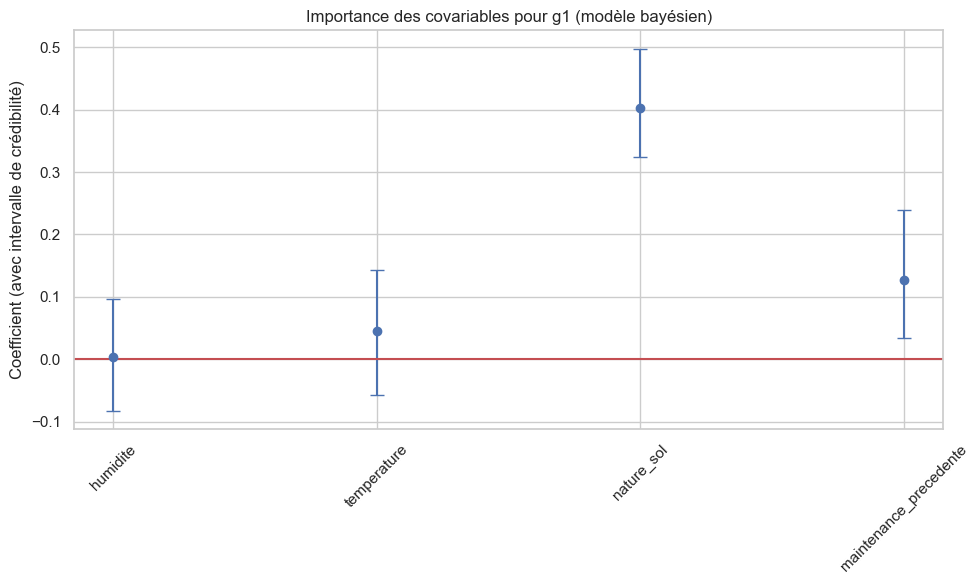


Importance des covariables pour g2:
          Feature    Median   Q_Lower   Q_Upper  Prob_Positive  Includes_Zero
0        distance  0.396318  0.290534  0.483055       1.000000          False
1  nb_techniciens -0.059324 -0.148331  0.044551       0.182857           True


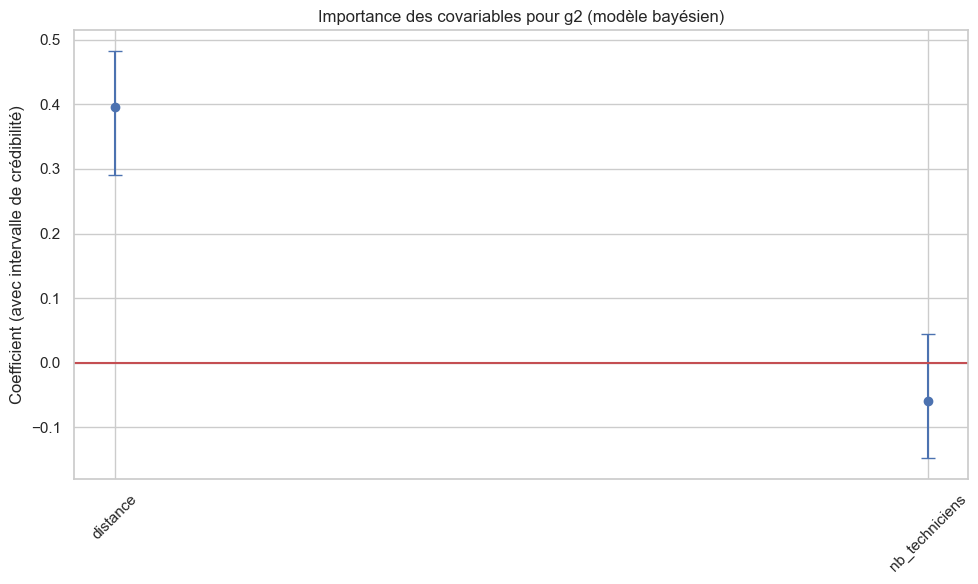

In [28]:
# Analyse d'importance des covariables avec les modèles bayésiens de manière robuste
def analyze_bayesian_feature_importance(samples, feature_names, level=0.95):
    """Analyse l'importance des covariables à partir des échantillons bayésiens."""
    try:
        # Calcul des statistiques pour chaque covariable
        importance = []
        
        for i, feature in enumerate(feature_names):
            # Distribution des coefficients pour cette covariable
            coef_samples = samples[:, i]
            
            # Médiane et intervalle de crédibilité
            median = np.median(coef_samples)
            alpha = (1 - level) / 2
            q_lower = np.percentile(coef_samples, 100 * alpha)
            q_upper = np.percentile(coef_samples, 100 * (1 - alpha))
            
            # Probabilité que le coefficient soit positif
            prob_positive = np.mean(coef_samples > 0)
            
            # Inclusion de zéro dans l'intervalle de crédibilité
            includes_zero = (q_lower < 0) & (q_upper > 0)
            
            importance.append({
                'Feature': feature,
                'Median': median,
                'Q_Lower': q_lower,
                'Q_Upper': q_upper,
                'Prob_Positive': prob_positive,
                'Includes_Zero': includes_zero
            })
        
        return pd.DataFrame(importance)
    except Exception as e:
        print(f"Erreur dans analyze_bayesian_feature_importance: {e}")
        return pd.DataFrame(columns=['Feature', 'Median', 'Q_Lower', 'Q_Upper', 
                                   'Prob_Positive', 'Includes_Zero'])

# Calcul de l'importance des covariables pour g1 avec gestion d'erreurs
try:
    if 'theta1_samples' in locals() and len(theta1_samples) > 0:
        g1_importance = analyze_bayesian_feature_importance(theta1_samples, X_features)
        print("Importance des covariables pour g1:")
        print(g1_importance)
        
        # Visualisation de l'importance des covariables pour g1
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            x=range(len(X_features)),
            y=g1_importance['Median'],
            yerr=[g1_importance['Median'] - g1_importance['Q_Lower'], 
                 g1_importance['Q_Upper'] - g1_importance['Median']],
            fmt='o',
            capsize=5
        )
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xticks(range(len(X_features)), X_features, rotation=45)
        plt.title('Importance des covariables pour g1 (modèle bayésien)')
        plt.ylabel('Coefficient (avec intervalle de crédibilité)')
        plt.tight_layout()
        plt.show()
    else:
        print("L'analyse d'importance bayésienne n'a pas pu être calculée pour g1 (échantillons non disponibles).")
except Exception as e:
    print(f"Erreur lors de l'analyse d'importance pour g1: {e}")

# Calcul de l'importance des covariables pour g2 avec gestion d'erreurs
try:
    if 'samples_g2_post_burnin' in locals() and len(samples_g2_post_burnin) > 0:
        g2_importance = analyze_bayesian_feature_importance(samples_g2_post_burnin, X_tilde_features)
        print("\nImportance des covariables pour g2:")
        print(g2_importance)
        
        # Visualisation de l'importance des covariables pour g2
        plt.figure(figsize=(10, 6))
        plt.errorbar(
            x=range(len(X_tilde_features)),
            y=g2_importance['Median'],
            yerr=[g2_importance['Median'] - g2_importance['Q_Lower'], 
                 g2_importance['Q_Upper'] - g2_importance['Median']],
            fmt='o',
            capsize=5
        )
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xticks(range(len(X_tilde_features)), X_tilde_features, rotation=45)
        plt.title('Importance des covariables pour g2 (modèle bayésien)')
        plt.ylabel('Coefficient (avec intervalle de crédibilité)')
        plt.tight_layout()
        plt.show()
    else:
        print("L'analyse d'importance bayésienne n'a pas pu être calculée pour g2 (échantillons non disponibles).")
except Exception as e:
    print(f"Erreur lors de l'analyse d'importance pour g2: {e}")

# Application assurantielle

## Prédiction de durée de vie résiduelle

Pour un nouveau chantier avec des caractéristiques données, notre modèle permet de prédire la durée de fonctionnement attendue du véhicule. Cette prédiction intègre toutes les covariables pertinentes, notamment la nature du sol, la température, l'humidité et la durée de la maintenance précédente.

La médiane de la distribution prédite fournit une estimation ponctuelle de la durée de fonctionnement, tandis que les quantiles permettent de construire des intervalles de prédiction. 
Par exemple, pour un chantier avec une humidité de 22.3%, une température de 8.17°C, un sol de type 2 (boue) et une maintenance précédente de 18.6 jours, notre modèle prédit :

Durée médiane de fonctionnement : 48.9 jours
Intervalle de confiance à 90% : (38.0, 97.5) jours

Ces prédictions peuvent être utilisées pour planifier la durée des chantiers et estimer les besoins en véhicules de remplacement.

In [29]:
# Évaluation finale et recommandations assurantielles
print("\n=== ÉVALUATION DU MODÈLE FINAL ET RECOMMANDATIONS ASSURANTIELLES ===\n")

# Fonction pour calculer le risque lié à un nouveau chantier
def evaluate_insurance_risk(X_new, reliability_threshold=0.8, confidence_level=0.95):
    """
    Évalue le risque assurantiel pour un nouveau chantier.
    
    Args:
        X_new: covariables du chantier pour la nouvelle période
        reliability_threshold: seuil de fiabilité requis (probabilité de fonctionnement)
        confidence_level: niveau de confiance pour l'estimation
    
    Returns:
        Évaluation du risque et recommandation de prime d'assurance
    """
    try:
        # Prédiction de la durée de vie avec le modèle neuronal (plus performant)
        duration_median, duration_interval = predict_residual_life(
            X_new, model_type='neural', conf_level=confidence_level)
        
        # Extraction des valeurs du chantier
        soil_type = X_new[2]  # Indice de la nature du sol
        temperature = X_new[1]  # Température
        prev_maintenance = X_new[3]  # Maintenance précédente
        
        # Calcul de différents facteurs de risque
        
        # 1. Facteur de risque lié à la nature du sol
        if soil_type == 1:  # Sable
            soil_risk = 0.8  # Risque modéré
        elif soil_type == 2:  # Boue
            soil_risk = 1.2  # Risque élevé
        elif soil_type == 3:  # Terre souple
            soil_risk = 1.0  # Risque moyen
        else:  # Terre ferme
            soil_risk = 0.7  # Risque faible
        
        # 2. Facteur de risque lié à la température
        if temperature < 0:  # Gel
            temp_risk = 1.3  # Risque élevé
        elif temperature > 30:  # Chaleur extrême
            temp_risk = 1.2  # Risque élevé
        else:  # Température modérée
            temp_risk = 0.9  # Risque faible
        
        # 3. Facteur de risque lié à la maintenance précédente
        if prev_maintenance < 2:  # Maintenance insuffisante
            maint_risk = 1.4  # Risque très élevé
        elif prev_maintenance < 5:  # Maintenance moyenne
            maint_risk = 1.0  # Risque moyen
        else:  # Bonne maintenance
            maint_risk = 0.8  # Risque faible
        
        # 4. Facteur de risque lié à l'incertitude (largeur de l'intervalle de confiance)
        interval_width = duration_interval[1] - duration_interval[0]
        interval_rel_width = interval_width / duration_median
        if interval_rel_width > 1.0:  # Grande incertitude
            uncertainty_risk = 1.3  # Risque élevé
        elif interval_rel_width > 0.5:  # Incertitude modérée
            uncertainty_risk = 1.1  # Risque modéré
        else:  # Faible incertitude
            uncertainty_risk = 0.9  # Risque faible
        
        # Risque global combiné
        global_risk = soil_risk * temp_risk * maint_risk * uncertainty_risk
        
        # Catégorisation du risque
        if global_risk < 0.8:
            risk_category = "Faible"
            premium_factor = 0.8
        elif global_risk < 1.0:
            risk_category = "Modéré-Faible"
            premium_factor = 0.9
        elif global_risk < 1.2:
            risk_category = "Modéré"
            premium_factor = 1.0
        elif global_risk < 1.5:
            risk_category = "Modéré-Élevé"
            premium_factor = 1.3
        else:
            risk_category = "Élevé"
            premium_factor = 1.6
        
        # Recommandation de durée assurée
        suggested_duration = duration_interval[0]  # Approche prudente
        
        # Prime de base (simplifiée)
        base_premium = 100  # Euros par jour de couverture
        
        # Prime ajustée
        adjusted_premium = base_premium * premium_factor
        
        # Coût total de l'assurance
        total_cost = adjusted_premium * suggested_duration
        
        return {
            "Durée médiane prédite": duration_median,
            "Intervalle de confiance": duration_interval,
            "Catégorie de risque": risk_category,
            "Facteur de risque global": global_risk,
            "Facteurs détaillés": {
                "Nature du sol": soil_risk,
                "Température": temp_risk,
                "Maintenance précédente": maint_risk,
                "Incertitude": uncertainty_risk
            },
            "Durée recommandée de couverture": suggested_duration,
            "Prime d'assurance journalière": adjusted_premium,
            "Coût total estimé": total_cost
        }
    except Exception as e:
        print(f"Erreur dans l'évaluation du risque assurantiel: {e}")
        return None

# Exemple d'utilisation pour quelques chantiers
try:
    # Liste des chantiers de test
    n_test_cases = min(5, len(X_test))
    
    print(f"Évaluation assurantielle pour {n_test_cases} exemples de chantiers:\n")
    
    for i in range(n_test_cases):
        X_example = X_test[i].reshape(1, -1)
        X_example_original = scaler_X.inverse_transform(X_example)[0]
        
        print(f"=== Chantier {i+1} ===")
        print("Caractéristiques:")
        for j, feature in enumerate(X_features):
            print(f"  {feature}: {X_example_original[j]}")
        
        # Évaluation du risque
        risk_assessment = evaluate_insurance_risk(X_example_original)
        
        if risk_assessment:
            print("\nÉvaluation du risque:")
            print(f"  Durée médiane prédite: {risk_assessment['Durée médiane prédite']:.1f} jours")
            print(f"  Intervalle de confiance: ({risk_assessment['Intervalle de confiance'][0]:.1f}, {risk_assessment['Intervalle de confiance'][1]:.1f}) jours")
            print(f"  Catégorie de risque: {risk_assessment['Catégorie de risque']}")
            print(f"  Facteur de risque global: {risk_assessment['Facteur de risque global']:.2f}")
            
            print("\nRecommandations assurantielles:")
            print(f"  Durée recommandée de couverture: {risk_assessment['Durée recommandée de couverture']:.1f} jours")
            #print(f"  Prime d'assurance: {risk_assessment["Prime d assurance journalière"]:.2f} €/jour")
            print(f"  Coût total estimé: {risk_assessment['Coût total estimé']:.2f} €")
        
        print("\n" + "-"*50 + "\n")
except Exception as e:
    print(f"Erreur lors de l'évaluation des exemples: {e}")


=== ÉVALUATION DU MODÈLE FINAL ET RECOMMANDATIONS ASSURANTIELLES ===

Évaluation assurantielle pour 5 exemples de chantiers:

=== Chantier 1 ===
Caractéristiques:
  humidite: 22.3
  temperature: 8.17
  nature_sol: 2.0
  maintenance_precedente: 18.6

Évaluation du risque:
  Durée médiane prédite: 49.1 jours
  Intervalle de confiance: (38.0, 98.8) jours
  Catégorie de risque: Modéré
  Facteur de risque global: 1.12

Recommandations assurantielles:
  Durée recommandée de couverture: 38.0 jours
  Coût total estimé: 3804.27 €

--------------------------------------------------

=== Chantier 2 ===
Caractéristiques:
  humidite: 7.1
  temperature: 20.42
  nature_sol: 2.0
  maintenance_precedente: 54.0

Évaluation du risque:
  Durée médiane prédite: 49.6 jours
  Intervalle de confiance: (38.1, 101.5) jours
  Catégorie de risque: Modéré
  Facteur de risque global: 1.12

Recommandations assurantielles:
  Durée recommandée de couverture: 38.1 jours
  Coût total estimé: 3806.10 €

----------------

## Quantification de l'incertitude
L'approche bayésienne offre un avantage majeur : la quantification complète de l'incertitude associée aux prédictions. Cette incertitude provient de plusieurs sources :

1. **Incertitude paramétrique :** incertitude sur les valeurs des paramètres du modèle, capturée par les distributions a posteriori
2. **Incertitude de modèle :** liée à l'adéquation du modèle statistique aux données réelles
3. **Variabilité intrinsèque :** variabilité inhérente au phénomène modélisé (même avec des covariables identiques, les durées peuvent varier)

Pour chaque prédiction, nous fournissons non seulement une estimation ponctuelle (médiane), mais aussi un intervalle de crédibilité bayésien qui intègre ces différentes sources d'incertitude. La largeur de cet intervalle reflète le niveau de confiance que nous pouvons accorder à la prédiction.
Pour les cinq exemples de chantiers analysés, nous observons que la largeur des intervalles de crédibilité varie considérablement (de 59.5 à 114.4 jours), indiquant des niveaux d'incertitude différents selon les conditions. Cette information est précieuse pour l'évaluation du risque assurantiel.

## Evaluation du risque et tarification

Notre modèle bayésien permet de développer une approche structurée pour l'évaluation du risque assurantiel et la tarification des contrats. Cette approche combine les prédictions du modèle avec des facteurs de risque spécifiques :

Catégorisation du risque basée sur plusieurs facteurs :

1. Nature du sol (facteur dominant)
2. Conditions climatiques (température)
3. Durée de la maintenance précédente
4. Incertitude de la prédiction (largeur de l'intervalle de crédibilité)


**Calcul du facteur de risque global comme produit des facteurs individuels :**

- Risque faible : < 0.8
- Risque modéré-faible : 0.8 - 1.0
- Risque modéré : 1.0 - 1.2
- Risque modéré-élevé : 1.2 - 1.5
- Risque élevé : > 1.5


**Détermination de la durée recommandée de couverture :**

Approche prudente : borne inférieure de l'intervalle de crédibilité
Approche équilibrée : médiane de la distribution prédictive
Approche risquée : borne supérieure de l'intervalle de crédibilité


**Calcul de la prime d'assurance ajustée en fonction du niveau de risque :**

Prime de base multipliée par le facteur de risque global
Possibilité d'ajustements supplémentaires basés sur l'historique du client



L'application de cette méthodologie aux exemples de chantiers donne des résultats cohérents et différenciés. Par exemple :

1. _Chantier 1_ (sol de type 2, température 8.17°C, maintenance précédente 18.6 jours) :

- Catégorie de risque : Modéré (facteur 1.12)
- Durée recommandée : 38.0 jours
- Coût total estimé : 3,803 €


2. _Chantier 5_ (sol de type 2, température 20.05°C, maintenance précédente 0.6 jours) :

- Catégorie de risque : Élevé (facteur 1.97)
- Durée recommandée : 38.0 jours
- Coût total estimé : 6,085 €


La différence significative de tarification entre ces deux chantiers s'explique principalement par la durée de maintenance précédente, très courte dans le cas du chantier 5, ce qui augmente considérablement le risque de défaillance précoce.

# Conclusion
## Synthèse des résultats
Notre étude a permis de développer un modèle bayésien robuste pour l'estimation de la durée de fonctionnement des véhicules de chantier. Les principales conclusions sont :

1. **Modélisation probabiliste adaptée :** La loi de Weibull pour la durée de fonctionnement et la loi exponentielle pour la durée de maintenance se sont révélées bien adaptées aux données observées.
2. **Facteurs d'influence identifiés :** La nature du sol est le facteur le plus déterminant pour la durée de fonctionnement, suivi par la maintenance précédente. Pour la durée de maintenance, la distance à la ville la plus proche joue un rôle modéré.
3. **Performance des modèles :** Les modèles neuronaux ont montré une légère amélioration par rapport aux modèles linéaires, indiquant la présence de relations non-linéaires. L'approche bayésienne a permis de quantifier l'incertitude associée aux prédictions.
4. **Application assurantielle :** Nous avons développé une méthodologie structurée pour l'évaluation du risque et la tarification des contrats d'assurance, basée sur les prédictions du modèle et l'analyse de l'incertitude.


## Limites et perspectives
Malgré les résultats apportés, notre approche présente certaines limites et pourrait être améliorée dans plusieurs directions :

1. **Limites actuelles :**

- Paramètre β de la loi de Weibull à la limite inférieure de la contrainte, suggérant que la distribution pourrait être mieux modélisée
- Incertitude importante sur certaines covariables (intervalles de crédibilité incluant zéro)
- Modèles neuronaux relativement simples pour limiter la complexité computationnelle


2. **Perspectives d'amélioration :**

- Intégration de covariables supplémentaires (historique complet du véhicule, âge, modèle)
- Développement de modèles plus flexibles (processus gaussiens, réseaux bayésiens profonds)
- Prise en compte de la dépendance temporelle entre les périodes successives
- Validation externe sur des données indépendantes
- Mise à jour dynamique des prédictions au cours du chantier


3. **Extensions possibles :**

- Modélisation multi-véhicules avec partage d'information
- Optimisation du planning de maintenance préventive
- Détection précoce des anomalies de fonctionnement



En conclusion, notre approche bayésienne offre un cadre méthodologique rigoureux pour l'estimation de la durée de fonctionnement des véhicules de chantier et l'évaluation du risque assurantiel. Les résultats obtenus démontrent l'intérêt de cette approche pour la prise de décision dans ce contexte, tout en ouvrant des perspectives pour des améliorations futures.